Исходные данные были предоставлены в формате xlsb, с большим количеством связанных таблиц и формул.  
Ввиду долгой работы Excel при практически любом действии в таких таблицах, я решил использовать более удобный инструмент для работы с подобными данными: python + библиотеки для этого языка + jupyter notebook для создания пошагового отчета.

In [2]:
# Загружаем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 50)

#### 1. Первичный анализ данных

In [9]:
# Загружаем данные
df = pd.read_csv('case_data.csv')

C:\Users\sa_alyoshin\AppData\Local\Temp\ipykernel_5232\1372333882.py:2: DtypeWarning: Columns (5,19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('case_data.csv')


In [10]:
# Посмотрим общую информацию о типах данных и заполненности датафрейма
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80912 entries, 0 to 80911
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   источник                           80912 non-null  object 
 1   год                                80912 non-null  int64  
 2   квартал                            80912 non-null  int64  
 3   месяц                              74556 non-null  float64
 4   неделя                             49168 non-null  float64
 5   день                               1737 non-null   object 
 6   регион                             76614 non-null  object 
 7   базовый индекс строки              80912 non-null  object 
 8   показатель                         80912 non-null  object 
 9   сумма                              79853 non-null  float64
 10  лифт                               6 non-null      float64
 11  min x                              80912 non-null  flo

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
год,80912.0,2022.654303,1.715476,2019.000000,2021.000000,2023.000000,2024.000000,2026.0
квартал,80912.0,2.570620,1.154685,0.000000,2.000000,3.000000,4.000000,4.0
месяц,74556.0,6.860266,3.777527,0.000000,4.000000,7.000000,10.000000,14.0
неделя,49168.0,26.899325,15.657083,0.000000,13.000000,27.000000,41.000000,53.0
сумма,79853.0,3454.493651,33395.694860,-49643.544516,0.000000,109.000000,378.880000,997107.0
лифт,6.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0
min x,80912.0,-14684.058099,22657.338162,-49643.544516,-49643.544516,0.000000,0.000000,1.0
max,80912.0,49283.546749,82571.796654,191.987869,777.740000,3525.000000,90536.225000,997107.0
преобразованное значение напрямую,80912.0,0.302000,0.234595,-0.000284,0.016478,0.354232,0.487155,1.0
СТАБИЛИЗИРОВАННО ДО МЕСЯЦ,44562.0,169938.077243,363726.611053,-1885.042581,180.000000,34633.126710,78921.716129,3794799.0


In [12]:
# Оставим только информативные столбцы. К сожалению, в таблице намешано все подряд и придется проверять корректность данных.
# Видим, что некоторые слова написаны с опечатками или же специально некорректно прописаны: 
# коЛЛичество рецептов, 
# факт Физита,
# квартал написан с доп пробелом, дальше не буду перечислять

selected_cols = [
    'источник', 
    'год', # быстрая проверка через groupby
    'месяц', # быстрая проверка через groupby
    'квартал ', # быстрая проверка через groupby
    'неделя', # быстрая проверка через groupby
    'день', # быстрая проверка через groupby
    'регион', # надо проверить на предмет уникальности, отсутствия опечаток
    'базовый индекс строки', # пока что не понятно, что это
    'показатель', # метрика, но это еще вопрос, как они сгруппированы
    'сумма', # сумма по метрике? 
    'режим календарь',
    'тип данных',

    # # все, что указано ниже, мне сейчас не требуется
    # 'лифт', 
    # 'min x', 
    # 'max',
    # 'преобразованное значение напрямую',
    # 'СТАБИЛИЗИРОВАННО ДО МЕСЯЦ',
    # 'MINX2',
    # 'MAXX2',
    # 'Пеобразованное значение'
    ]

#### 1.1. Группировка по источнику данных

In [13]:
# Выделяем уникальеые источники данныx
datasources = df['источник'].unique()

In [14]:
# Видим количество заполненных ячеек по источникам
df.groupby(by='источник')[[
        'год',
        'квартал ',
        'месяц', 
        'неделя',
        'день',
        'регион',
        'базовый индекс строки',
        'показатель',
        'сумма',
        'режим календарь',
        'тип данных',
        ]].agg(['count','nunique'])

год         квартал           месяц         неделя          \
                count nunique    count nunique  count nunique  count nunique   
источник                                                                       
GEO Month       25268       8    25268       4  25268      12      0       0   
GEO week        47432       7    47432       5  47432      15  47432      54   
Market           1736       5     1736       4   1736      12   1736      53   
TMA               120       2      120       4    120      12      0       0   
presc            1241       5     1241       4      0       0      0       0   
Визит FTE        2673       4     2673       4      0       0      0       0   
факт физита МП   2442       4     2442       4      0       0      0       0   

                день         регион         базовый индекс строки          \
               count nunique  count nunique                 count nunique   
источник                                                                    
GEO Month          0       0  25268      78                 25268    6317   
GEO week           1       1  47432     103                 47432   23716   
Market          1736     217      0       0                  1736     217   
TMA                0       0      0       0                   120      66   
presc              0       0   1241      20                  1241    1241   
Визит FTE          0       0   2673      72                  2673    2673   
факт физита МП     0       0      0       0                  2442     814   

               показатель          сумма         режим календарь          \
                    count nunique  count nunique           count nunique   
источник                                                                   
GEO Month           25268       4  25268   15001           25268       1   
GEO week            47432       2  47432    2635           47432       2   
Market               1736       8   1734    1380            1736       1   
TMA                   120       1    120      76             120       1   
presc                1241       1   1241     588            1241       1   
Визит FTE            2673       1   2480     927            2673       1   
факт физита МП       2442       1   1578     459            2442       1   

               тип данных          
                    count nunique  
источник                           
GEO Month           12634       1  
GEO week            47432       2  
Market               1736       2  
TMA                   120       1  
presc                1241       1  
Визит FTE            2673       1  
факт физита МП       2442       1

Заметки:  
1.Geo Month - помесячные данные (+ квартальные) по 78 регионам по 4 показателям, имеется 8 лет  
2.Geo Week - понедельные данные (+ кварталы, месяцы) по 103 регионам и 2 показателям, 2 режима календаря, имеется 7 лет:  
- особое внимание следует обратить на то, что в источниках, которые собираются для рекламных агентств, как правило больше недель и месяцев в году, чем принято считать, это связано с тем, что они фокусируются именно на недельных данных, 2 недели на стыке в начале и в конце года дают 52 + 2 = 54 недели, но 15 месяцев - для меня сюрприз  
- дополнительно: не понимаю, почему количество регионов, охваченных Geo Month, Geo Week так сильно отличается (на 25)

3.Маркет - похоже, что данные по дням (+ кварталы, месяцы, недели), по 8 показателям и 2 типам данных, имеется 5 лет  
4.TMA - помесячные данные по 1 показателю (суммарные ТМА, очевидно)  
5.presc - поквартальные данные по 1 показателю по 20 регионам, 5 лет  
6.Визит FTE - поквартальные данные по 1 показателю по 72 регионам за 4 года  
7.факт Визита МП - поквартальные данные по 1 показателю (! не понятно, где регионы, иначе зачем этот факт визита, смотрю сразу)

In [15]:
# смотрим, что у нас по факту визита МП и видим, что регионы есть, просто их нужно парсить из другой строки
df[df['источник'] == 'факт физита МП'].head(3)

,источник,год,квартал,месяц,неделя,день,регион,базовый индекс строки,показатель,сумма,лифт,min x,max,преобразованное значение напрямую,режим календарь,тип данных,СТАБИЛИЗИРОВАННО ДО МЕСЯЦ,MINX2,MAXX2,Пеобразованное значение
74556,факт физита МП,2021,1,NaN,NaN,NaN,NaN,2021-Q1_Алтайский край,факт физита,NaN,NaN,1.0,3525.0,-0.000284,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485
74557,факт физита МП,2021,1,NaN,NaN,NaN,NaN,2021-Q1_Алтайский край,факт физита,20.0,NaN,1.0,3525.0,0.005392,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485
74558,факт физита МП,2021,1,NaN,NaN,NaN,NaN,2021-Q1_Алтайский край,факт физита,144.0,NaN,1.0,3525.0,0.040579,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485


In [16]:
# заполним недостаюие значения по фактам визита МП
df['регион2'] = df['базовый индекс строки'].str.extract(r'_(.+)$')
df['регион'] = df['регион'].fillna(df['регион2'])

df[df['источник'] == 'факт физита МП'].head(3)

,источник,год,квартал,месяц,неделя,день,регион,базовый индекс строки,показатель,сумма,лифт,min x,max,преобразованное значение напрямую,режим календарь,тип данных,СТАБИЛИЗИРОВАННО ДО МЕСЯЦ,MINX2,MAXX2,Пеобразованное значение,регион2
74556,факт физита МП,2021,1,NaN,NaN,NaN,Алтайский край,2021-Q1_Алтайский край,факт физита,NaN,NaN,1.0,3525.0,-0.000284,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485,Алтайский край
74557,факт физита МП,2021,1,NaN,NaN,NaN,Алтайский край,2021-Q1_Алтайский край,факт физита,20.0,NaN,1.0,3525.0,0.005392,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485,Алтайский край
74558,факт физита МП,2021,1,NaN,NaN,NaN,Алтайский край,2021-Q1_Алтайский край,факт физита,144.0,NaN,1.0,3525.0,0.040579,Q,сумма квартал,14813.0,4517.0,34619.0,0.34203707394857485,Алтайский край


In [17]:
# проверяем, регионы появились в факте визита
# Видим количество заполненных ячеек по источникам
df.groupby(by='источник')[[
        'год',
        'квартал ',
        'месяц', 
        'неделя',
        'день',
        'регион',
        'базовый индекс строки',
        'показатель',
        'сумма',
        'режим календарь',
        'тип данных',
        ]].agg(['count','nunique'])

год         квартал           месяц         неделя          \
                count nunique    count nunique  count nunique  count nunique   
источник                                                                       
GEO Month       25268       8    25268       4  25268      12      0       0   
GEO week        47432       7    47432       5  47432      15  47432      54   
Market           1736       5     1736       4   1736      12   1736      53   
TMA               120       2      120       4    120      12      0       0   
presc            1241       5     1241       4      0       0      0       0   
Визит FTE        2673       4     2673       4      0       0      0       0   
факт физита МП   2442       4     2442       4      0       0      0       0   

                день         регион         базовый индекс строки          \
               count nunique  count nunique                 count nunique   
источник                                                                    
GEO Month          0       0  25268      78                 25268    6317   
GEO week           1       1  47432     103                 47432   23716   
Market          1736     217      0       0                  1736     217   
TMA                0       0    120      66                   120      66   
presc              0       0   1241      20                  1241    1241   
Визит FTE          0       0   2673      72                  2673    2673   
факт физита МП     0       0   2442      70                  2442     814   

               показатель          сумма         режим календарь          \
                    count nunique  count nunique           count nunique   
источник                                                                   
GEO Month           25268       4  25268   15001           25268       1   
GEO week            47432       2  47432    2635           47432       2   
Market               1736       8   1734    1380            1736       1   
TMA                   120       1    120      76             120       1   
presc                1241       1   1241     588            1241       1   
Визит FTE            2673       1   2480     927            2673       1   
факт физита МП       2442       1   1578     459            2442       1   

               тип данных          
                    count nunique  
источник                           
GEO Month           12634       1  
GEO week            47432       2  
Market               1736       2  
TMA                   120       1  
presc                1241       1  
Визит FTE            2673       1  
факт физита МП       2442       1

Заметки:  
1.Нас волнуют ключевые показатели по метрикам в разбивке по источникам. Очевидно, что наибольший интерес представляют помесячные данные и поквартальные - по ним больше всего записей, лет и источников  
2.Для анализа необходимо создать отдельные таблицы для каждого источника, чтобы удобно доставать метрики и срезы (сделаю в первую очередь)  
3.Столбец сумма претендует на единственный источник числовых данных для сравнения. В некоторых случая это будут продажи, в других - цены, в третьих - количество.

In [18]:
# создадим таблицы, ограничимся выделенными столбцами
datadict = {}
for src in datasources:
    datadict[src] = df[df['источник'] == src][[col for col in selected_cols if col != 'источник']]

In [19]:
# проверим названия таблиц, все получислось
datadict.keys()

dict_keys(['Market', 'GEO week', 'GEO Month', 'TMA', 'факт физита МП', 'Визит FTE', 'presc'])

In [20]:
market, geoweek, geomonth, tma, visits, visitsfte, presc = 'Market', 'GEO week', 'GEO Month', 'TMA', 'факт физита МП', 'Визит FTE', 'presc'

### 1.2. Анализ показателей

In [21]:
for dataframe in datadict:
    print(f'Показатели таблицы {dataframe}: {datadict[dataframe]["показатель"].unique()}', '\n')

Показатели таблицы Market: ['Кол-во запросов Yandex.Wordstat Конкуренты'
 'Кол-во запросов Yandex.Wordstat Петровакс'
 'Кол-во ТВ рейтингов Конкуренты' 'Кол-во ТВ рейтингов Петровакс'
 'Продажи (упаковки) Конкуренты' 'Продажи (упаковки) Петровакс'
 'Цена за 1 упаковку Конкуренты' 'Цена за 1 упаковку Петровакс'] 

Показатели таблицы GEO week: ['Продажи (упаковки) Петровакс' 'Цена за 1 упаковку Петровакс'] 

Показатели таблицы GEO Month: ['Продажи (упаковки)_Конкуренты' 'Продажи (упаковки)_Петровакс'
 'Цена за 1 упаковку_Конкуренты' 'Цена за 1 упаковку_Петровакс'] 

Показатели таблицы TMA: ['TRADE INVESTMENT '] 

Показатели таблицы факт физита МП: ['факт физита'] 

Показатели таблицы Визит FTE: ['Визит FTE'] 

Показатели таблицы presc: ['колличество рецептов'] 



Заметки:  
1.Количество запросов, рейтингов: только Market  
2.Цены, продажи: Market, GEO week, GEO Month  
3.Вложения в TMA: TMA  
4.Визиты: Визит FTE  
5.Рецепты: presc

#### 1.2.1. Продажи/цены

Заметки:
Посмотрим на верхнеуровневые метрики, то есть без углубления в регионы:
- суммы по продажам Петровакс и конкурентов  
- средние цены Петровакс и конкурентов  

Подобная информация имеется только в таблицах Market и Geo Month

In [22]:
market_sales_metrics = [
    'Продажи (упаковки) Конкуренты', 
    'Продажи (упаковки) Петровакс',
    ] 

market_prices_metrics = [
    'Цена за 1 упаковку Конкуренты', 
    'Цена за 1 упаковку Петровакс'
]

geo_month_sales_metrics = [
    'Продажи (упаковки)_Конкуренты',
    'Продажи (упаковки)_Петровакс',
    ]

geo_month_prices_metrics = [
    'Цена за 1 упаковку_Конкуренты',
    'Цена за 1 упаковку_Петровакс'
]

In [23]:
# Обрежем все данные с 2021 по 2024 год включительно
# Это не всегда корректно, но в данном случае для графиков и мини-анализа приемлемо
df.groupby(by='источник')['год'].agg(['min', 'max'])

,min,max
источник,,
GEO Month,2019,2026
GEO week,2020,2026
Market,2021,2025
TMA,2023,2024
presc,2020,2024
Визит FTE,2021,2024
факт физита МП,2021,2024


Ограничимся 2021 - 2024 гг.

In [24]:
for source in datasources:
    if source == 'TMA':
        continue
    datadict[source] = datadict[source][(datadict[source]['год'] >= 2021) & ((datadict[source]['год'] <= 2024))]

In [25]:
def plot_metrics(data, source, metrics_list, function):

    temp_df = data[source]  # Получаем DataFrame для текущего рынка

    plt.figure(figsize=(12,5))
    for metric in metrics_list:  # Перебираем показатели
        filtered_df = temp_df[temp_df['показатель'] == metric]  # Фильтруем данные по показателю
        
        if function == 'sum':

            grouped_data = (
                filtered_df
                .groupby(by=['год', 'месяц'])['сумма']
                .sum()
                .reset_index()
            )
        
        if function == 'mean':
            
            grouped_data = (
                filtered_df
                .groupby(by=['год', 'месяц'])['сумма']
                .mean()
                .reset_index()
            )

        # Создаем метки для оси X (например, "2020-01")
        x_labels = grouped_data.apply(lambda row: f"{int(row['год'])}-{int(row['месяц'])}", axis=1)
        
        # Строим график
        plt.plot(
            x_labels,  # Метки для оси X
            grouped_data['сумма'],  # Значения для оси Y
            label=f"{source} - {metric}"  # Легенда
        )
        
    # Настройка графика
    plt.xlabel('Год-Месяц')
    plt.ylabel('Сумма')
    plt.xticks(rotation=45, fontsize=8)  # Поворачиваем метки для лучшей читаемости
    plt.legend()
    plt.tight_layout()  # Автоматическая настройка расположения элементов
    plt.show()

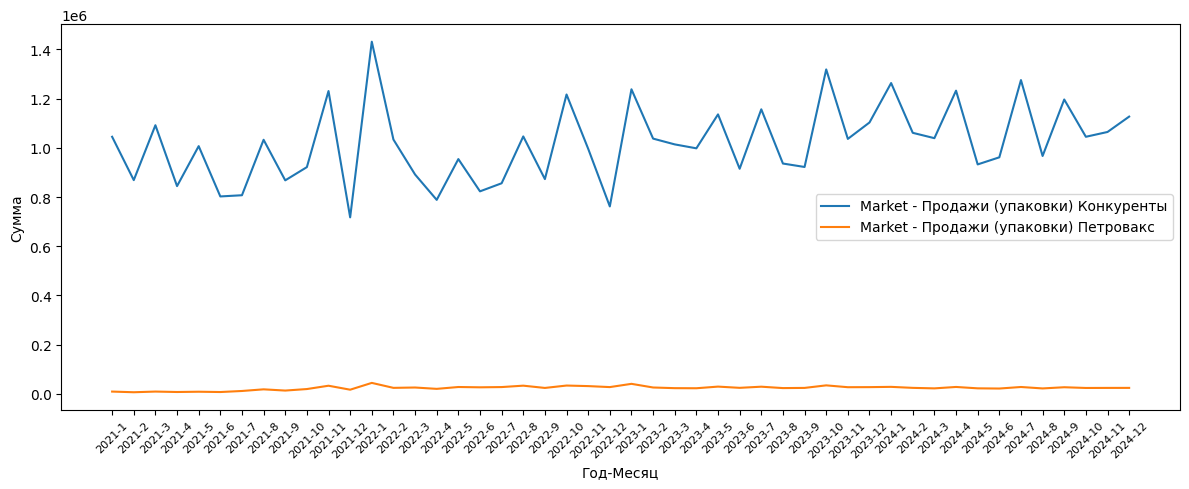

In [26]:
# Видим, что доля Петровакс относительно конкурентов мала
# При желании, можно нормализовать обе переменные, но я этого делать не буду
plot_metrics(datadict, market, market_sales_metrics, 'sum')

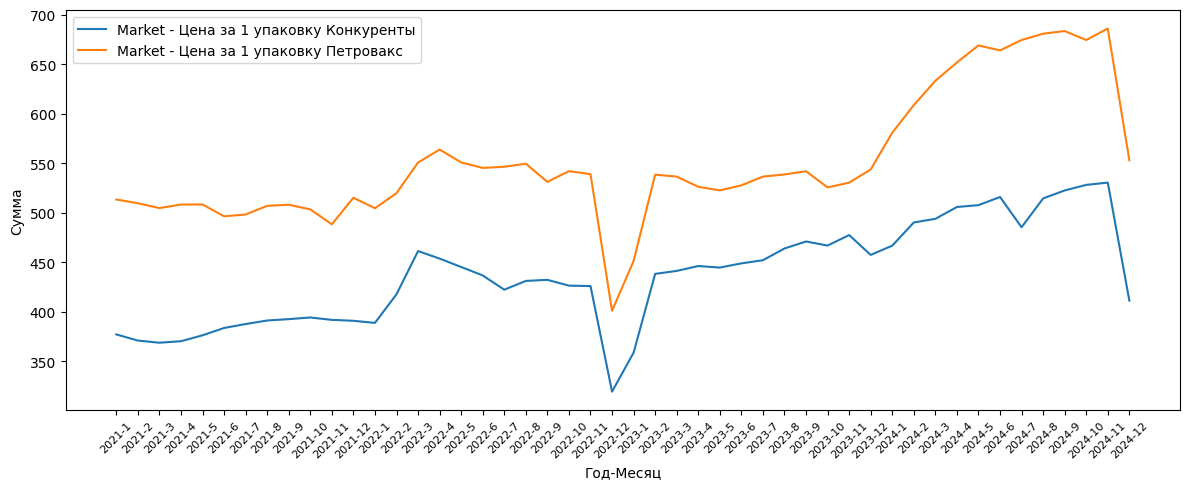

In [27]:
plot_metrics(datadict, market, market_prices_metrics, 'mean')

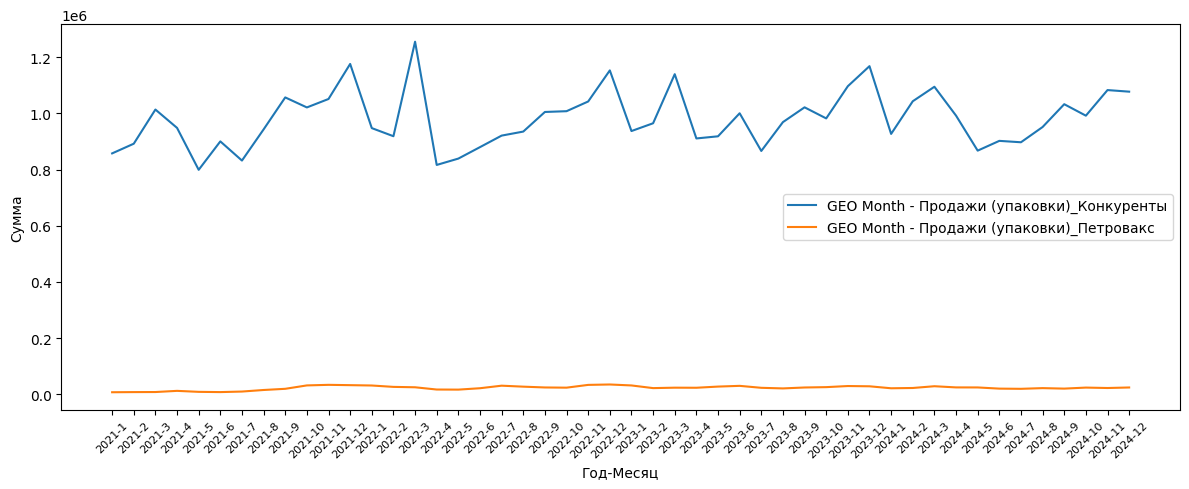

In [28]:
plot_metrics(datadict, geomonth, geo_month_sales_metrics, 'sum')

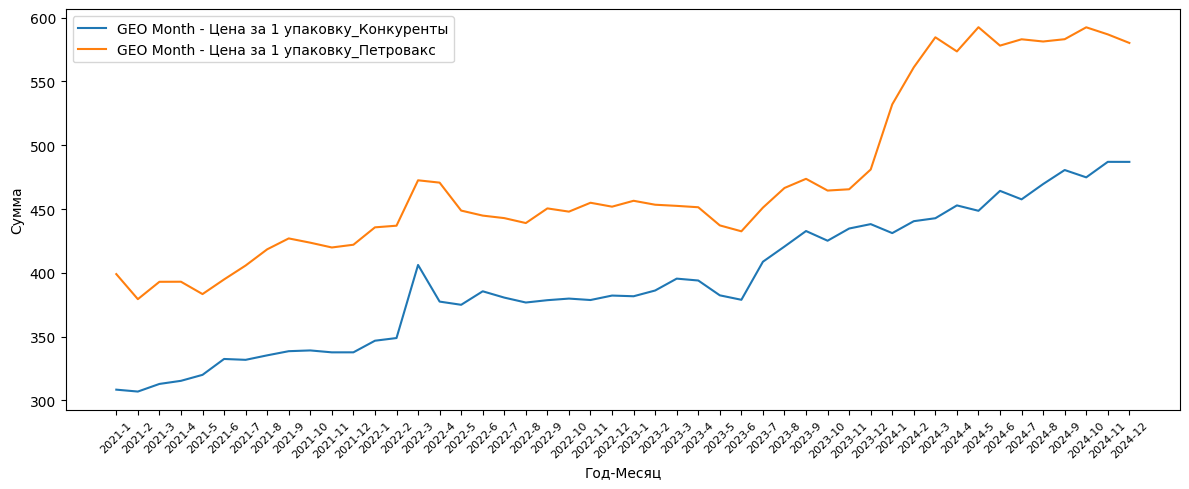

In [29]:
plot_metrics(datadict, geomonth, geo_month_prices_metrics, 'mean')

Заметки: поведение графиков Market и Geo Month отличается, нужно наложить графики друг на друга, чтобы было наглядно

In [30]:
def plot_metrics_compared(data, source1, source2, metric1, metric2, function):

    temp_df1 = data[source1].copy() 
    temp_df2 = data[source2].copy()

    plt.figure(figsize=(12,5))
    
    filtered_df1 = temp_df1[temp_df1['показатель'] == metric1]
    filtered_df2 = temp_df2[temp_df2['показатель'] == metric2]
        
    if function == 'sum':

        grouped_data1 = (
            filtered_df1
            .groupby(by=['год', 'месяц'])['сумма']
            .sum()
            .reset_index()
        )

        grouped_data2 = (
            filtered_df2
            .groupby(by=['год', 'месяц'])['сумма']
            .sum()
            .reset_index()
        )
    
    if function == 'mean':
        
        grouped_data1 = (
            filtered_df1
            .groupby(by=['год', 'месяц'])['сумма']
            .mean()
            .reset_index()
        )

        grouped_data2 = (
            filtered_df2
            .groupby(by=['год', 'месяц'])['сумма']
            .mean()
            .reset_index()
        )


    x_labels1 = grouped_data1.apply(lambda row: f"{int(row['год'])}-{int(row['месяц'])}", axis=1)
    x_labels2 = grouped_data2.apply(lambda row: f"{int(row['год'])}-{int(row['месяц'])}", axis=1)
    

    plt.plot(
        x_labels1,  
        grouped_data1['сумма'],  
        label=f"{source1} - {metric1}" 
    )

    plt.plot(
        x_labels2,  
        grouped_data2['сумма'],  
        label=f"{source2} - {metric2}"  
        )
        

    plt.xlabel('Год-Месяц')
    plt.ylabel('Сумма')
    plt.xticks(rotation=45, fontsize=8) 
    plt.legend()
    plt.tight_layout() 
    plt.show()

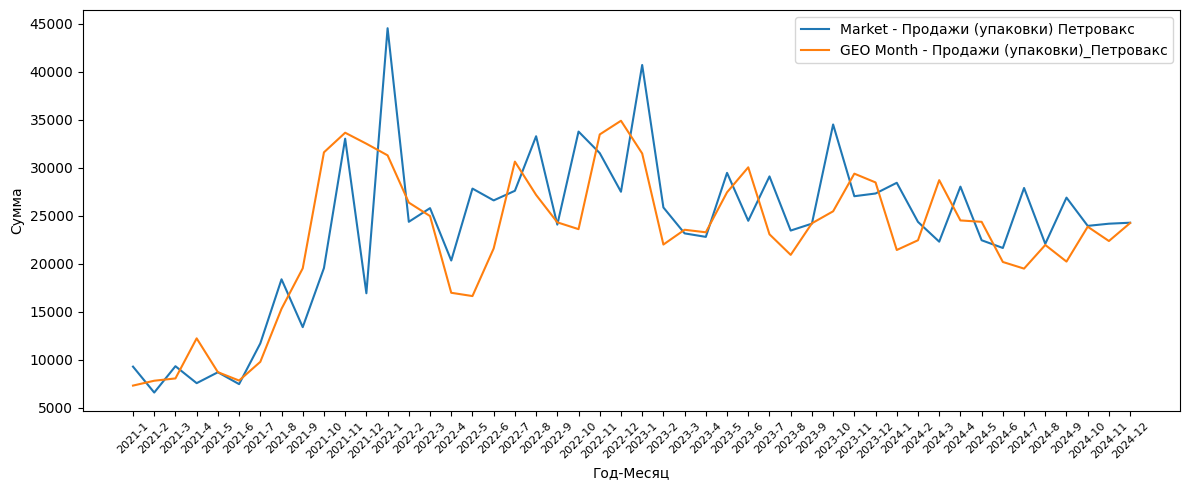

In [31]:
plot_metrics_compared(datadict, market, geomonth, market_sales_metrics[1], geo_month_sales_metrics[1], 'sum')

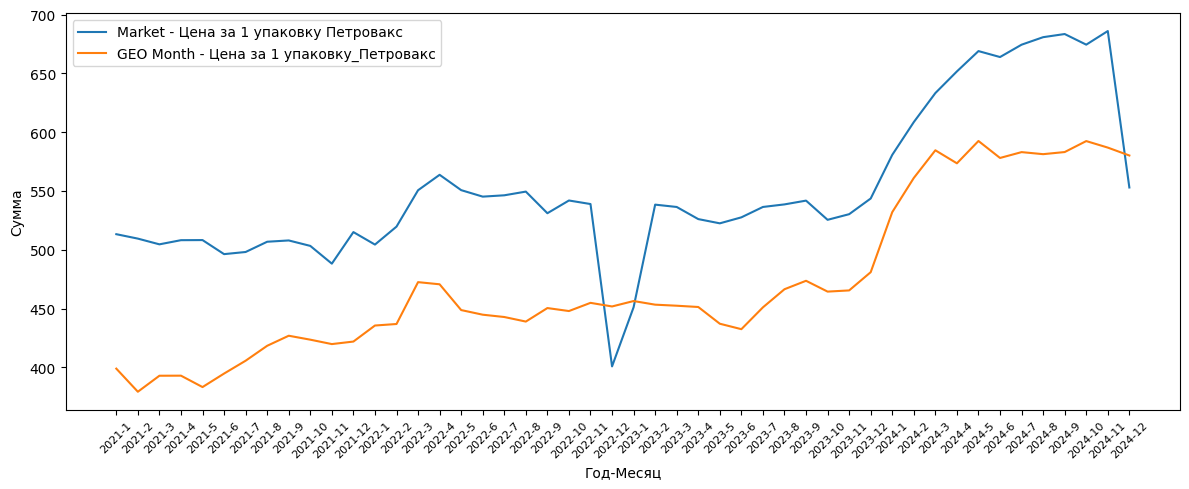

In [32]:
plot_metrics_compared(datadict, market, geomonth, market_prices_metrics[1], geo_month_prices_metrics[1], 'mean')

Временные ряды из источников Market и Geo Month визуально отличаются, что заметно невооруженным глазом:  
-по продажам: Geo Month показывает более "сглаженные показатели", когда Market более "резкий"  
-по ценам: Geo Month занижает цены в диапазоне от 100 до 20-30 единиц в зависимости от периода. Макрет имеет тенденцию раз в два года показывать
резкое понижение цены в ноябре:
- Судя по тому, что поведение показателей возвращается к норме уже к январю, и такая тенденция как минимум дважды прослеживается за указанный период в одно и то же время, данный "выброс" может быть следствием выбросов в конкрентый месяц в седствие усреднения

Взглянем на аналогичные показатели у конкурентов

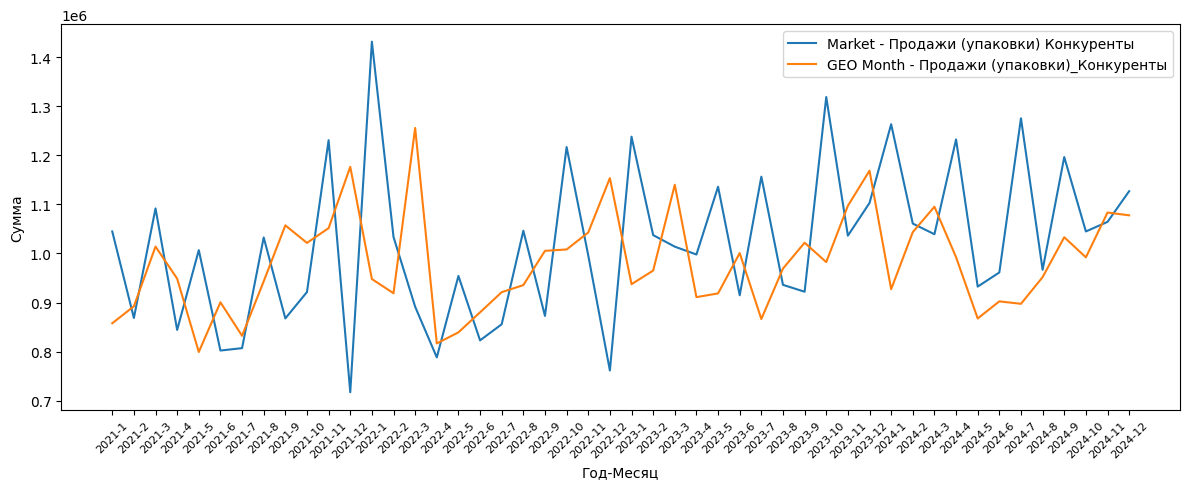

In [33]:
plot_metrics_compared(datadict, market, geomonth, market_sales_metrics[0], geo_month_sales_metrics[0], 'sum')

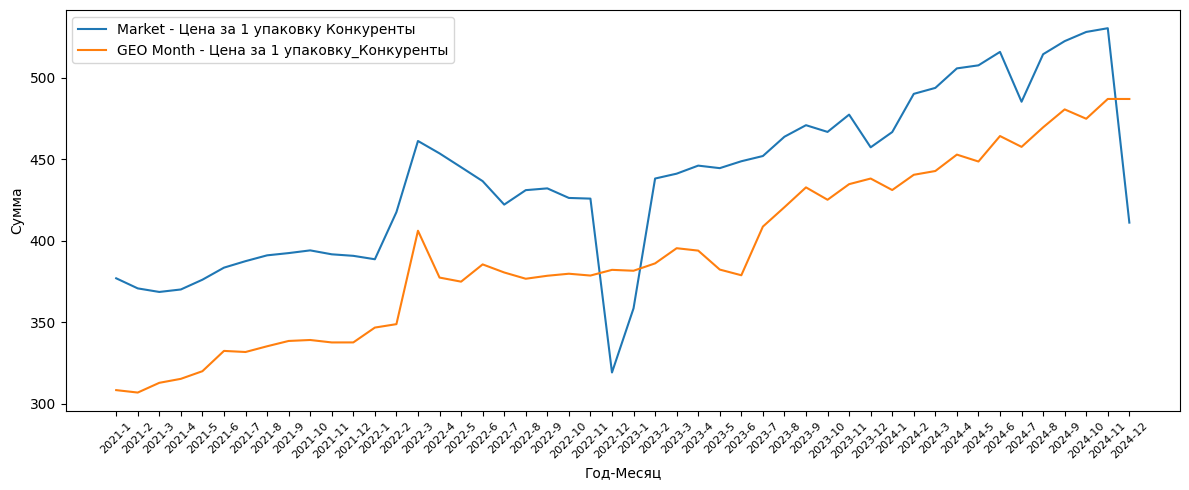

In [34]:
plot_metrics_compared(datadict, market, geomonth, market_prices_metrics[0], geo_month_prices_metrics[0], 'mean')

Посмотрим на графики медианных значений

In [35]:
def plot_metrics_compared_median(data, source1, source2, metric1, metric2, function):

    temp_df1 = data[source1].copy() 
    temp_df2 = data[source2].copy()

    plt.figure(figsize=(12,5))
    
    filtered_df1 = temp_df1[temp_df1['показатель'] == metric1]
    filtered_df2 = temp_df2[temp_df2['показатель'] == metric2]
        
    if function == 'sum':

        grouped_data1 = (
            filtered_df1
            .groupby(by=['год', 'месяц'])['сумма']
            .sum()
            .reset_index()
        )

        grouped_data2 = (
            filtered_df2
            .groupby(by=['год', 'месяц'])['сумма']
            .sum()
            .reset_index()
        )
    
    if function == 'median':
        
        grouped_data1 = (
            filtered_df1
            .groupby(by=['год', 'месяц'])['сумма']
            .median()
            .reset_index()
        )

        grouped_data2 = (
            filtered_df2
            .groupby(by=['год', 'месяц'])['сумма']
            .median()
            .reset_index()
        )


    x_labels1 = grouped_data1.apply(lambda row: f"{int(row['год'])}-{int(row['месяц'])}", axis=1)
    x_labels2 = grouped_data2.apply(lambda row: f"{int(row['год'])}-{int(row['месяц'])}", axis=1)
    
 
    plt.plot(
        x_labels1,
        grouped_data1['сумма'],
        label=f"{source1} - {metric1}" 
    )

    plt.plot(
        x_labels2, 
        grouped_data2['сумма'],  
        label=f"{source2} - {metric2}" 
        )
        
    # Настройка графика
    plt.xlabel('Год-Месяц')
    plt.ylabel('Сумма')
    plt.xticks(rotation=45, fontsize=8) 
    plt.legend()
    plt.tight_layout() 
    plt.show()

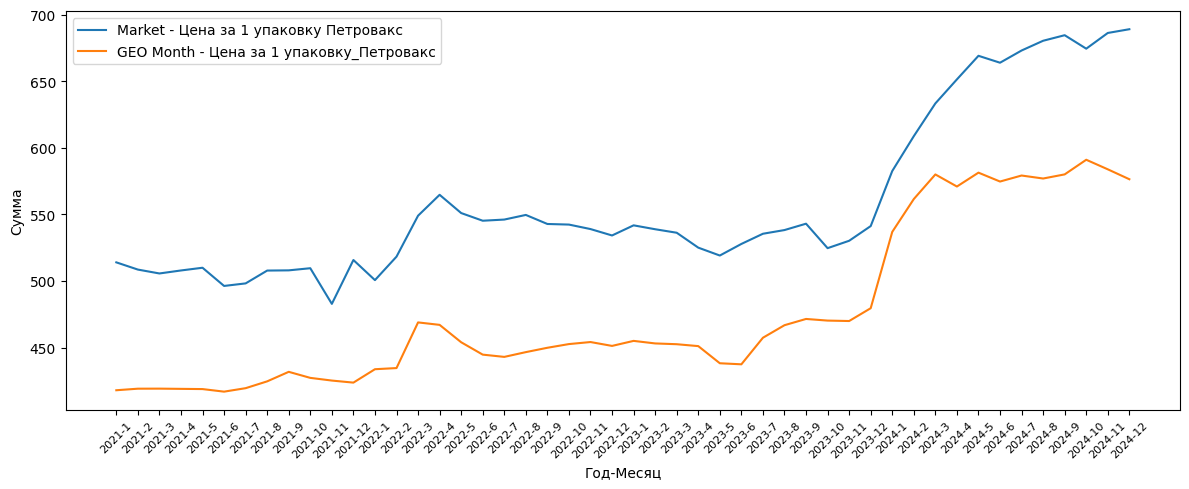

In [36]:
plot_metrics_compared_median(datadict, market, geomonth, market_prices_metrics[1], geo_month_prices_metrics[1], 'median')

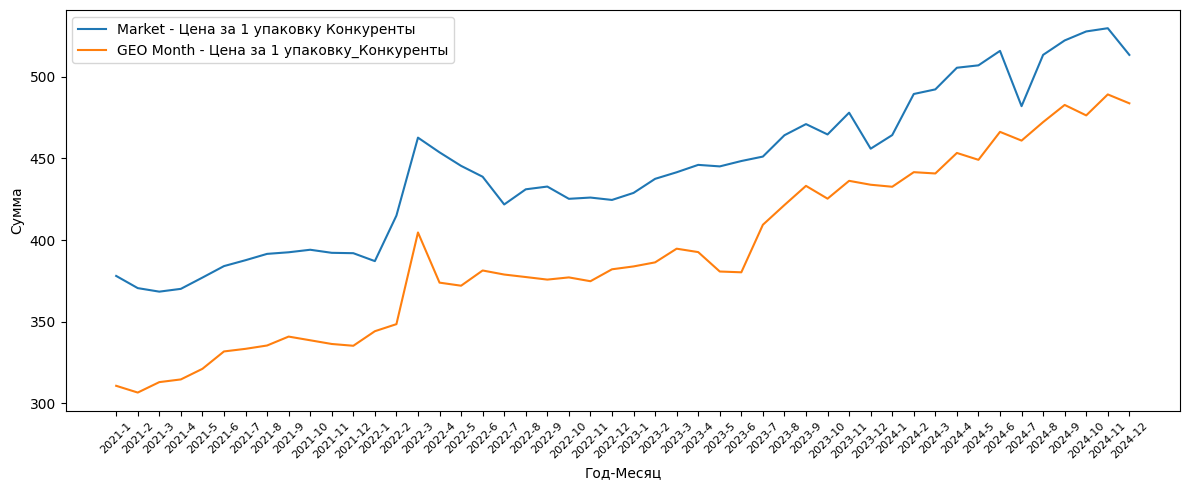

In [37]:
plot_metrics_compared_median(datadict, market, geomonth, market_prices_metrics[0], geo_month_prices_metrics[0], 'median')

Видим, что использование медианных показателей сглаживает графики, а это значит, что причина падений при усреднении - выбросы. Будем использовать медианные цены для простоты. Можно бесконечно анализировать графики и исправлять данные. Сейчас фокус на другом - посмотреть на данные, понять возможные точки роста, если текущие данные предоставляют возможность их найти.

Оставлю только данные по Market по причине того, что данные идут сразу аггрегированные, без разбивки по регионам, то есть можно избежать необходимости взвештвать продажи по каждому региону. Важно заметить, что региональная разбивка очень важна, в данном случае я ее не использую только из соображений времени.

In [38]:
market_features = pd.pivot_table(
    data=datadict[market],
    values='сумма',
    index=['год', 'месяц'],
    columns='показатель',
    aggfunc=['sum', 'median']
    )

market_features.columns = [
    f"{agg}_{metric}" for agg, metric in market_features.columns
]

In [39]:
# выделим ключевые метрики для анализа
focus_cols = [
    'median_Цена за 1 упаковку Конкуренты',
    'median_Цена за 1 упаковку Петровакс',
    'sum_Продажи (упаковки) Конкуренты',
    'sum_Продажи (упаковки) Петровакс',
    ]

In [40]:
# функция для добавления информации по колонкам
def add_transformed_columns(df):
    transformed_df = df.copy()
    
    for column in df.select_dtypes(include=['number']).columns:
        transformed_df[f'diff_{column}'] = df[column].diff()
        
        # transformed_df[f'rolling_mean_{column}'] = df[column].rolling(window=2).mean()
        # transformed_df[f'rolling_mean_{column}'] = df[column].rolling(window=3).mean()

        transformed_df[f'pct_change_{column}'] = df[column].pct_change()

        # transformed_df[f'ewma_{column}'] = df[column].ewm(span=3).mean()

        # decomposition = seasonal_decompose(df[column], model='additive', period=12)

        # transformed_df[f'trend_{column}'] = decomposition.trend
        # transformed_df[f'seasonal_{column}'] = decomposition.seasonal
        # transformed_df[f'residual_{column}'] = decomposition.resid
        
        transformed_df.fillna(0, inplace = True)
    return transformed_df


In [41]:
# новый dataframe с отфильтрованными фокусными столбцами
focus_df = market_features[focus_cols]
# добавляем дополнительные метрики по столбцам
transformed_focus_df = add_transformed_columns(focus_df)

# Доступ к уровням MultiIndex ('год' и 'месяц')
years = transformed_focus_df.index.get_level_values('год').astype(str)
months = transformed_focus_df.index.get_level_values('месяц').astype(str)

# Создать столбец 'date', объединяя 'год' и 'месяц'
transformed_focus_df['date'] = years + '-' + months

# посмотрим на данные
transformed_focus_df.head(4)

median_Цена за 1 упаковку Конкуренты  \
год  месяц                                         
2021 1.0                              378.054337   
     2.0                              370.599015   
     3.0                              368.439013   
     4.0                              370.149564   

            median_Цена за 1 упаковку Петровакс  \
год  месяц                                        
2021 1.0                             513.991444   
     2.0                             508.570449   
     3.0                             505.650202   
     4.0                             507.901613   

            sum_Продажи (упаковки) Конкуренты  \
год  месяц                                      
2021 1.0                           1044834.12   
     2.0                            868676.38   
     3.0                           1091783.42   
     4.0                            844337.04   

            sum_Продажи (упаковки) Петровакс  \
год  месяц                                     
2021 1.0                             9264.06   
     2.0                             6560.84   
     3.0                             9307.72   
     4.0                             7540.60   

            diff_median_Цена за 1 упаковку Конкуренты  \
год  месяц                                              
2021 1.0                                     0.000000   
     2.0                                    -7.455322   
     3.0                                    -2.160002   
     4.0                                     1.710551   

            pct_change_median_Цена за 1 упаковку Конкуренты  \
год  месяц                                                    
2021 1.0                                           0.000000   
     2.0                                          -0.019720   
     3.0                                          -0.005828   
     4.0                                           0.004643   

            diff_median_Цена за 1 упаковку Петровакс  \
год  месяц                                             
2021 1.0                                    0.000000   
     2.0                                   -5.420994   
     3.0                                   -2.920247   
     4.0                                    2.251411   

            pct_change_median_Цена за 1 упаковку Петровакс  \
год  месяц                                                   
2021 1.0                                          0.000000   
     2.0                                         -0.010547   
     3.0                                         -0.005742   
     4.0                                          0.004453   

            diff_sum_Продажи (упаковки) Конкуренты  \
год  месяц                                           
2021 1.0                                      0.00   
     2.0                                -176157.74   
     3.0                                 223107.04   
     4.0                                -247446.38   

            pct_change_sum_Продажи (упаковки) Конкуренты  \
год  месяц                                                 
2021 1.0                                        0.000000   
     2.0                                       -0.168599   
     3.0                                        0.256836   
     4.0                                       -0.226644   

            diff_sum_Продажи (упаковки) Петровакс  \
год  месяц                                          
2021 1.0                                     0.00   
     2.0                                 -2703.22   
     3.0                                  2746.88   
     4.0                                 -1767.12   

            pct_change_sum_Продажи (упаковки) Петровакс      date  
год  месяц                                                         
2021 1.0                                       0.000000  2021-1.0  
     2.0                                      -0.291796  2021-2.0  
     3.0                                       0.418678  2021-3.0  
     4.0                       

In [42]:
def plot_selected_metrics(data, col_list):
    temp_df = data.copy()
    temp_df = temp_df[col_list]

    plt.figure(figsize=(10, 5))

    for col in col_list:
        if col != 'date':
            plt.plot(temp_df['date'], temp_df[col], label=f'{col}')
        plt.ylabel('')
    plt.xticks(rotation=45, fontsize=8)
    plt.legend()
    plt.show()

In [43]:
transformed_focus_df['total_sales_volume'] = transformed_focus_df['sum_Продажи (упаковки) Конкуренты'] + transformed_focus_df['sum_Продажи (упаковки) Петровакс']
transformed_focus_df['sales_vol_share_pretrovax'] = transformed_focus_df['sum_Продажи (упаковки) Петровакс']/transformed_focus_df['total_sales_volume']
transformed_focus_df['diff_sales_share_pretrovax'] = transformed_focus_df['sales_vol_share_pretrovax'].diff().fillna(0)

transformed_focus_df['sales_value_petrovax'] = transformed_focus_df['sum_Продажи (упаковки) Петровакс'] * transformed_focus_df['median_Цена за 1 упаковку Петровакс']
transformed_focus_df['sales_value_competitors'] = transformed_focus_df['sum_Продажи (упаковки) Конкуренты'] * transformed_focus_df['median_Цена за 1 упаковку Конкуренты']
transformed_focus_df['total_sales_value'] = transformed_focus_df['sales_value_petrovax'] + transformed_focus_df['sales_value_competitors']
transformed_focus_df['sales_value_share_pretrovax'] = transformed_focus_df['sales_value_petrovax'] / transformed_focus_df['total_sales_value']


transformed_focus_df['price_ratio_petrovax_competitors'] = transformed_focus_df['median_Цена за 1 упаковку Петровакс'] / transformed_focus_df['median_Цена за 1 упаковку Конкуренты']

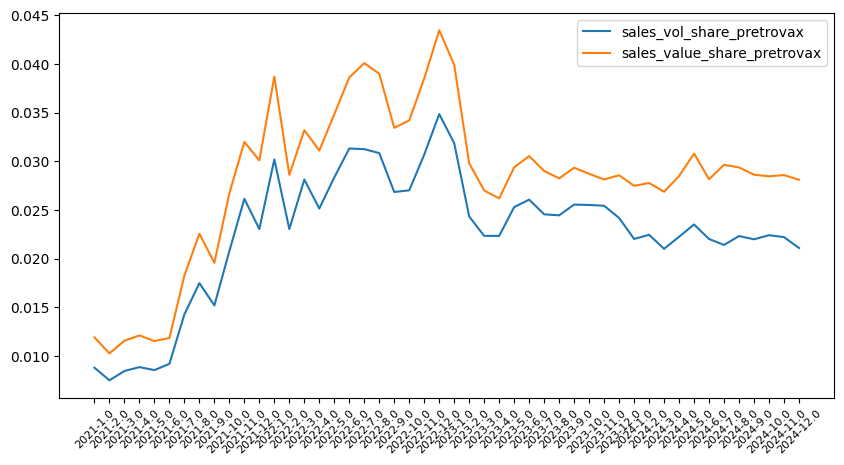

In [44]:
plot_selected_metrics(transformed_focus_df, [
    'sales_vol_share_pretrovax',
    'sales_value_share_pretrovax',
    # 'price_ratio_petrovax_competitors',
    'date'
    ])

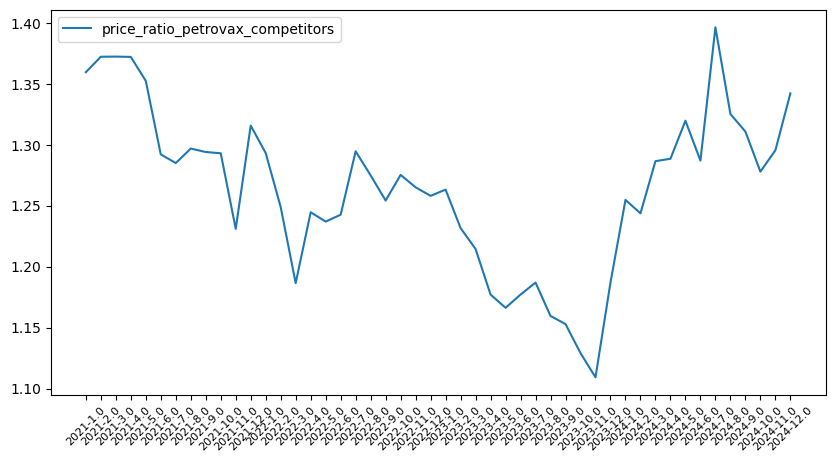

In [45]:
plot_selected_metrics(transformed_focus_df, ['price_ratio_petrovax_competitors', 'date'])

Заметки:  
1.Доля рынка по объему продаж упаковок выросла с ~0.8% до ~2,5% за указанный период  
2.Доля рынка по выручке выросла с 1% до 3%  
3.Причина разрывов в 1. и 2. на втором графике - более высокие цены Петровакс в сравнении с конкурентами

##### Прогнозирование

Попробуем построить прогноз для продаж и цен Петровакс

In [46]:
from prophet import Prophet
import cmdstanpy

c:\Users\sa_alyoshin\AppData\Local\anaconda3\envs\kaggle_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
transformed_focus_df.columns

Index(['median_Цена за 1 упаковку Конкуренты',
       'median_Цена за 1 упаковку Петровакс',
       'sum_Продажи (упаковки) Конкуренты', 'sum_Продажи (упаковки) Петровакс',
       'diff_median_Цена за 1 упаковку Конкуренты',
       'pct_change_median_Цена за 1 упаковку Конкуренты',
       'diff_median_Цена за 1 упаковку Петровакс',
       'pct_change_median_Цена за 1 упаковку Петровакс',
       'diff_sum_Продажи (упаковки) Конкуренты',
       'pct_change_sum_Продажи (упаковки) Конкуренты',
       'diff_sum_Продажи (упаковки) Петровакс',
       'pct_change_sum_Продажи (упаковки) Петровакс', 'date',
       'total_sales_volume', 'sales_vol_share_pretrovax',
       'diff_sales_share_pretrovax', 'sales_value_petrovax',
       'sales_value_competitors', 'total_sales_value',
       'sales_value_share_pretrovax', 'price_ratio_petrovax_competitors'],
      dtype='object')

In [48]:
pvx_price = transformed_focus_df[['median_Цена за 1 упаковку Петровакс']].rename(columns={'median_Цена за 1 упаковку Петровакс': 'y'})
pvx_sales = transformed_focus_df[['sum_Продажи (упаковки) Петровакс']].rename(columns={'sum_Продажи (упаковки) Петровакс': 'y'})

In [49]:
def add_dates(df):
    data = df.copy()
    data = data.reset_index()
    data['месяц'] = data['месяц'].astype('int')
    data['date'] = pd.to_datetime(data['год'].astype('str') + '-' + data['месяц'].astype('str') + '-01')
    return data[['y', 'date']]

In [50]:
pvx_price = add_dates(pvx_price)
pvx_sales = add_dates(pvx_sales)

##### SARIMA и pvx_sales

In [101]:
pvx_sales['diff_y'] = pvx_sales['y'].diff().fillna(0)

In [102]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера
result = adfuller(pvx_sales['diff_y'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Ряд нестационарен. Увеличьте d или D.")
else:
    print("Ряд стационарен.")

ADF Statistic: -8.247825659737895
p-value: 5.492907024599154e-13
Ряд стационарен.


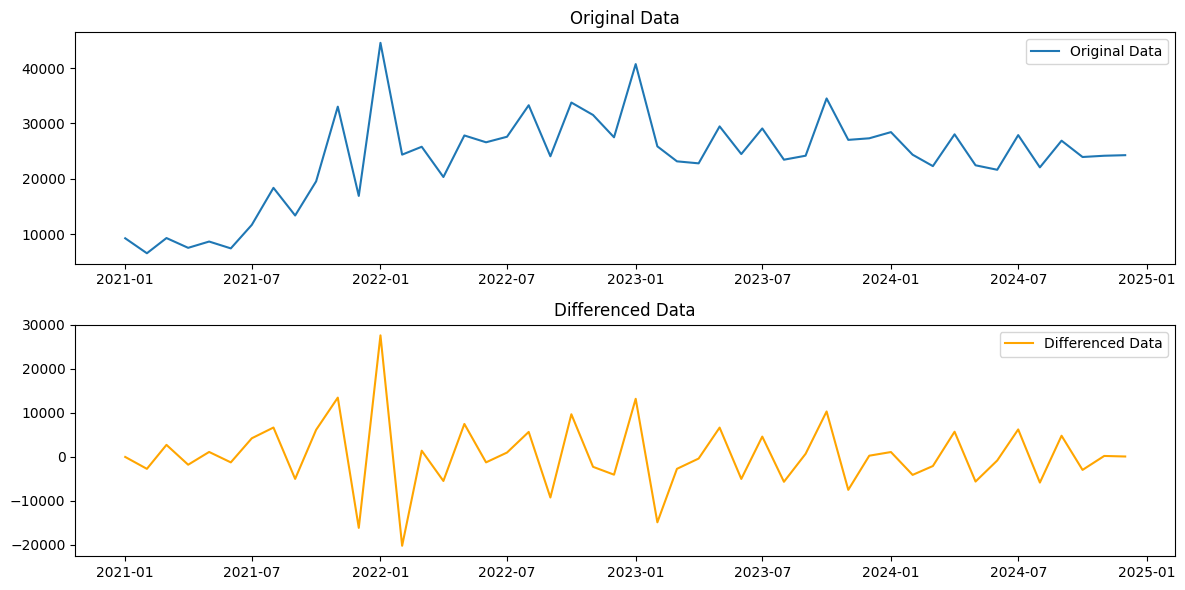

In [111]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(pvx_sales['date'], pvx_sales['y'], label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pvx_sales['date'], pvx_sales['diff_y'], label='Differenced Data', color='orange')
plt.title('Differenced Data')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

In [108]:
from pmdarima import auto_arima

model = auto_arima(
    pvx_sales['y'],
    seasonal=True,
    m=12,  # Сезонный период
    trace=True,
    stepwise=True
)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=953.525, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=981.414, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=949.072, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=953.288, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=979.500, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=957.455, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=942.549, Time=0.31 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=950.838, Time=0.34 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=943.984, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=972.285, Time=0.09 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=947.937, Time=0.13 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=949.756, Time=0.16 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=955.925, Time=0.12 sec
 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=950.632, Time=0.39 sec
 ARIMA(1,1,0)(2,0,0)[12]         

Mean Squared Error: 6683331.130750464


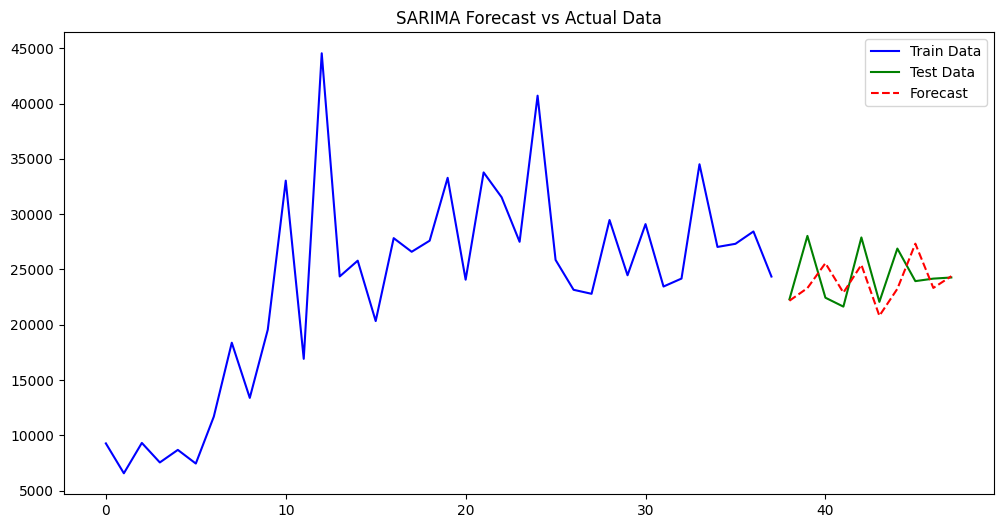

In [110]:
# Исходные данные
# pvx_sales['y'] - исходный временной ряд
# pvx_sales['diff_y'] - стационарный ряд (не используется напрямую)

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(pvx_sales['y']) * 0.8)
train, test = pvx_sales['y'][:train_size], pvx_sales['y'][train_size:]

# Построение модели SARIMA
model = SARIMAX(
    train, 
    order=(1, 1, 0),                # Параметры ARIMA
    seasonal_order=(2, 0, 0, 12)    # Сезонные параметры
)
model_fit = model.fit(disp=False)

# Прогнозирование
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Оценка качества прогноза
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('SARIMA Forecast vs Actual Data')
plt.legend()
plt.show()

Не идеально, но можно работать

##### SARIMA и pvx_prices (должно получиться не очень хорошо ввиду того, что ряд цен очень сильно меняет поведение в 2024 году)

In [112]:
pvx_price['diff_y'] = pvx_price['y'].diff().fillna(0)

In [113]:
from statsmodels.tsa.stattools import adfuller

# Тест Дики-Фуллера
result = adfuller(pvx_sales['diff_y'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] > 0.05:
    print("Ряд нестационарен. Увеличьте d или D.")
else:
    print("Ряд стационарен.")

ADF Statistic: -8.247825659737895
p-value: 5.492907024599154e-13
Ряд стационарен.


Ниже на графике мы видим резкий рост средних цен справа

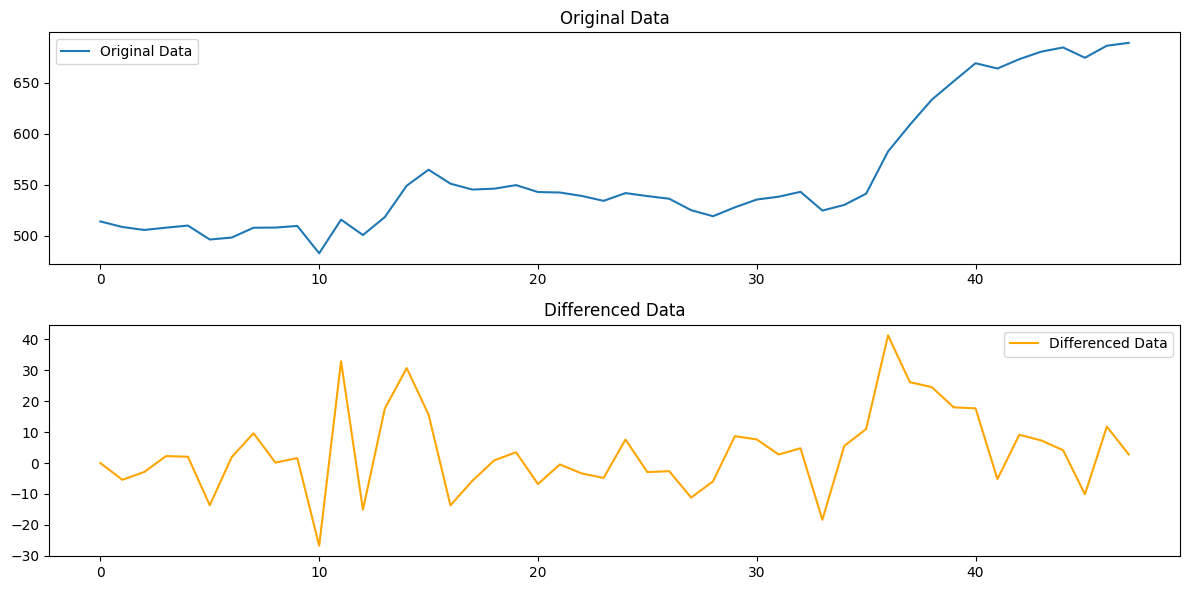

In [114]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(pvx_price.index, pvx_price['y'], label='Original Data')
plt.title('Original Data')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(pvx_price.index, pvx_price['diff_y'], label='Differenced Data', color='orange')
plt.title('Differenced Data')
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
model1 = auto_arima(
    pvx_price['y'],
    seasonal=True,
    m=9,  # Сезонный период
    trace=True,
    stepwise=True
)
print(model1.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[9] intercept   : AIC=386.276, Time=0.45 sec
 ARIMA(0,1,0)(0,0,0)[9] intercept   : AIC=381.592, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[9] intercept   : AIC=381.667, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[9] intercept   : AIC=381.773, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[9]             : AIC=383.071, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[9] intercept   : AIC=380.798, Time=0.10 sec
 ARIMA(0,1,0)(2,0,0)[9] intercept   : AIC=382.533, Time=0.15 sec
 ARIMA(0,1,0)(1,0,1)[9] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,1,0)(0,0,1)[9] intercept   : AIC=380.436, Time=0.04 sec
 ARIMA(0,1,0)(0,0,2)[9] intercept   : AIC=381.830, Time=0.08 sec
 ARIMA(0,1,0)(1,0,2)[9] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,1,0)(0,0,1)[9] intercept   : AIC=381.465, Time=0.11 sec
 ARIMA(1,1,1)(0,0,1)[9] intercept   : AIC=382.680, Time=0.12 sec
 ARIMA(0,1,0)(0,0,1)[9]             : AIC=383.851, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,1)[9] intercept
Total fi

c:\Users\sa_alyoshin\AppData\Local\anaconda3\envs\kaggle_env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Mean Squared Error: 6128.874654814472


c:\Users\sa_alyoshin\AppData\Local\anaconda3\envs\kaggle_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


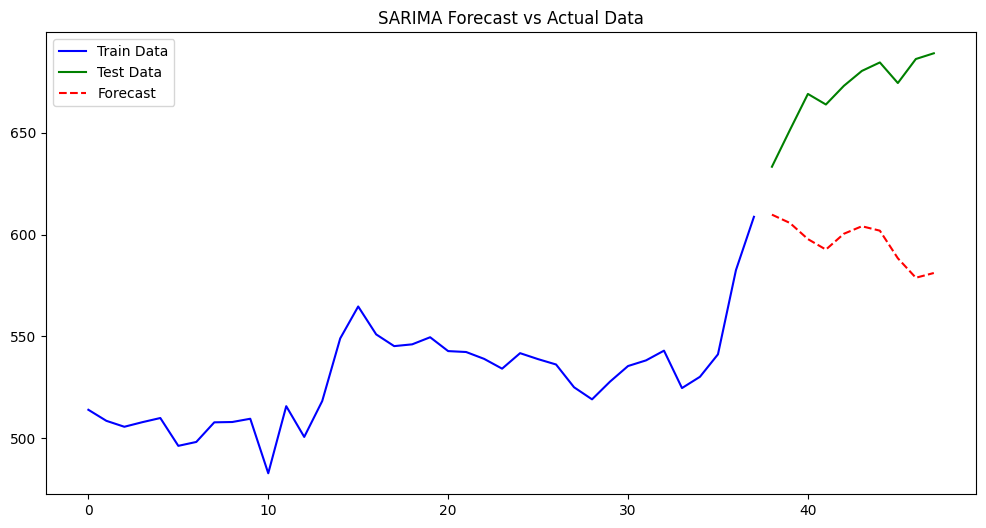

In [138]:
# Исходные данные
# pvx_sales['y'] - исходный временной ряд
# pvx_sales['diff_y'] - стационарный ряд (не используется напрямую)

# Разделение данных на обучающую и тестовую выборки
train_size = int(len(pvx_price['y']) * 0.8)
train, test = pvx_price['y'][:train_size], pvx_price['y'][train_size:]

# Построение модели SARIMA
model = SARIMAX(
    train, 
    order=(2, 1, 2),                # Параметры ARIMA
    seasonal_order=(1, 0, 1, 9)    # Сезонные параметры
)
model_fit = model.fit(disp=False)

# Прогнозирование
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Оценка качества прогноза
mse = mean_squared_error(test, forecast)
print(f"Mean Squared Error: {mse}")

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train Data', color='blue')
plt.plot(test.index, test, label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('SARIMA Forecast vs Actual Data')
plt.legend()
plt.show()

Получается плохо, даже с ручным перебором параметров, тут нужно анализировать более детально, это требует времени

#### 1.2.2. Все основные признаки (продажи, рейтинги и прочее), придется аггрегировать под квартальные данные

Продублирую ранее сделанную заметку:

Дублированная Заметка:  
1.Geo Month - помесячные данные (+ квартальные) по 78 регионам по 4 показателям, имеется 8 лет  
2.Geo Week - понедельные данные (+ кварталы, месяцы) по 103 регионам и 2 показателям, 2 режима календаря, имеется 7 лет:  
- особое внимание следует обратить на то, что в источниках, которые собираются для рекламных агентств, как правило больше недель и месяцев в году, чем принято считать, это связано с тем, что они фокусируются именно на недельных данных, 2 недели на стыке в начале и в конце года дают 52 + 2 = 54 недели, но 15 месяцев - для меня сюрприз  
- дополнительно: не понимаю, почему количество регионов, охваченных Geo Month, Geo Week так сильно отличается (на 25)

3.Маркет - похоже, что данные по дням (+ кварталы, месяцы, недели), по 8 показателям и 2 типам данных, имеется 5 лет  
4.TMA - помесячные данные по 1 показателю (суммарные ТМА, очевидно)  
5.presc - поквартальные данные по 1 показателю по 20 регионам, 5 лет  
6.Визит FTE - поквартальные данные по 1 показателю по 72 регионам за 4 года  
7.факт Визита МП - поквартальные данные по 1 показателю (! не понятно, где регионы, иначе зачем этот факт визита, смотрю сразу)

Дублированный вывод всех показателей:    
Показатели таблицы Market: ['Кол-во запросов Yandex.Wordstat Конкуренты'
 'Кол-во запросов Yandex.Wordstat Петровакс'
 'Кол-во ТВ рейтингов Конкуренты' 'Кол-во ТВ рейтингов Петровакс'
 'Продажи (упаковки) Конкуренты' 'Продажи (упаковки) Петровакс'
 'Цена за 1 упаковку Конкуренты' 'Цена за 1 упаковку Петровакс'] 

Показатели таблицы GEO week: ['Продажи (упаковки) Петровакс' 'Цена за 1 упаковку Петровакс'] 

Показатели таблицы GEO Month: ['Продажи (упаковки)_Конкуренты' 'Продажи (упаковки)_Петровакс'
 'Цена за 1 упаковку_Конкуренты' 'Цена за 1 упаковку_Петровакс'] 

Показатели таблицы TMA: ['TRADE INVESTMENT '] 

Показатели таблицы факт физита МП: ['факт физита'] 

Показатели таблицы Визит FTE: ['Визит FTE'] 

Показатели таблицы presc: ['колличество рецептов'] 

In [140]:
datadict2 = datadict.copy()

for source in datasources:
    datadict2[source] = datadict2[source][(datadict2[source]['год'] >= 2023) & ((datadict2[source]['год'] <= 2024))]

In [151]:
def create_final_pivot_table(datadict2, datasources):
    # Список для хранения всех сводных таблиц
    pivot_tables = []

    # Проходим по каждому источнику данных
    for datasource in datasources:
        if datasource in datadict2:
            # Получаем таблицу из словаря
            df = datadict2[datasource]
            
            # Создаем сводную таблицу
            pivot = pd.pivot_table(
                df,
                index=['год', 'квартал '],
                values='сумма',
                columns='показатель',
                aggfunc=['median', 'mean', 'sum']
            )
            
            # Переименовываем столбцы в формате {aggfunc}_{feature_name}
            pivot.columns = [f"{aggfunc}_{feature_name}" for aggfunc, feature_name in pivot.columns]
            
            # Добавляем префикс к столбцам для уникальности
            pivot = pivot.add_prefix(f"{datasource}_")
            
            # Добавляем сводную таблицу в список
            pivot_tables.append(pivot)
        else:
            print(f"Таблица '{datasource}' отсутствует в datadict2.")
    
    # Объединяем все сводные таблицы горизонтально
    if pivot_tables:
        final_table = pd.concat(pivot_tables, axis=1)
    else:
        final_table = pd.DataFrame()  # Возвращаем пустую таблицу, если нет данных
    
    return final_table

In [165]:
qfeats = create_final_pivot_table(datadict2=datadict2, datasources=datasources)

In [166]:
qfeats = qfeats.drop(index=[(2023, 0), (2024, 0)])

In [168]:
qfeats = qfeats.loc[:, (qfeats != 0).any(axis=0)]

In [180]:
qfeats.fillna(0, inplace=True)

In [181]:
for col in qfeats.columns:
    print(col)

Market_median_Кол-во запросов Yandex.Wordstat Конкуренты
Market_median_Кол-во запросов Yandex.Wordstat Петровакс
Market_median_Продажи (упаковки) Конкуренты
Market_median_Продажи (упаковки) Петровакс
Market_median_Цена за 1 упаковку Конкуренты
Market_median_Цена за 1 упаковку Петровакс
Market_mean_Кол-во ТВ рейтингов Конкуренты
Market_mean_Кол-во ТВ рейтингов Петровакс
Market_mean_Кол-во запросов Yandex.Wordstat Конкуренты
Market_mean_Кол-во запросов Yandex.Wordstat Петровакс
Market_mean_Продажи (упаковки) Конкуренты
Market_mean_Продажи (упаковки) Петровакс
Market_mean_Цена за 1 упаковку Конкуренты
Market_mean_Цена за 1 упаковку Петровакс
Market_sum_Кол-во ТВ рейтингов Конкуренты
Market_sum_Кол-во ТВ рейтингов Петровакс
Market_sum_Кол-во запросов Yandex.Wordstat Конкуренты
Market_sum_Кол-во запросов Yandex.Wordstat Петровакс
Market_sum_Продажи (упаковки) Конкуренты
Market_sum_Продажи (упаковки) Петровакс
Market_sum_Цена за 1 упаковку Конкуренты
Market_sum_Цена за 1 упаковку Петровакс
G

##### GradientBoostingRegressor (продажи ~ запросы, визиты, рецепты, трейд инвестиции)

In [203]:
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

In [224]:
def gradient_boosting_analysis(data, features, target, n_est=100, lr=0.01, max_depth=4):
    """
    Функция для анализа данных и построения модели градиентного бустинга.
    
    Параметры:
    - data (pd.DataFrame): Исходный DataFrame с данными.
    - features (list): Список признаков для использования в модели.
    - target (str): Название целевой переменной.
    - n_est (int): Количество деревьев.
    - lr (float): Скорость обучения.
    - max_depth (int): Максимальная глубина деревьев.
    
    Возвращает:
    - None: Результаты выводятся в виде графиков.
    """
    # 1. Разделение данных на обучающую и тестовую выборки
    X = data[features]
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # 2. Обучение модели с фиксированными гиперпараметрами
    gb_model = GradientBoostingRegressor(
        n_estimators=n_est,  # Количество деревьев
        learning_rate=lr,  # Скорость обучения
        max_depth=max_depth,  # Максимальная глубина деревьев
        random_state=42
    )
    gb_model.fit(X_train, y_train)

    # 3. Прогнозирование на тестовой и обучающей выборках
    y_pred_test = gb_model.predict(X_test)
    y_pred_train = gb_model.predict(X_train)

    # 4. Feature importances
    feature_importances = pd.Series(gb_model.feature_importances_, index=features).sort_values(ascending=False)

    # 5. Создание единой фигуры
    plt.figure(figsize=(18, 10))

    # 5.1. График прогноза vs реальных значений (train и test) - наверху
    plt.subplot(2, 1, 1)
    # Историческая последовательность сохраняется
    all_y = pd.concat([y_train, y_test])  # Все реальные значения
    all_pred = np.concatenate([y_pred_train, y_pred_test])  # Все прогнозируемые значения
    
    # Разделяем train и test для отображения
    train_size = len(y_train)
    plt.plot(all_y.values[:train_size], label="Реальные значения (train)", color='blue', alpha=0.7)
    plt.plot(all_pred[:train_size], label="Прогнозируемые значения (train)", color='orange', linestyle='--', alpha=0.7)
    plt.plot(range(train_size, len(all_y)), all_y.values[train_size:], label="Реальные значения (test)", color='green', alpha=0.7)
    plt.plot(range(train_size, len(all_y)), all_pred[train_size:], label="Прогнозируемые значения (test)", color='red', linestyle='--', alpha=0.7)
    
    plt.xlabel("Наблюдения (в исторической последовательности)")
    plt.ylabel("Значения")
    plt.legend()
    plt.title("Прогноз vs Реальные значения (train и test)")

    # 5.2. Гиперпараметры и метрика MSE - слева внизу
    plt.subplot(2, 2, 3)
    mse_train = root_mean_squared_error(y_train, y_pred_train)
    mse_test = root_mean_squared_error(y_test, y_pred_test)
    plt.text(0.1, 0.5, f"Гиперпараметры:\n"
                       f"n_estimators={n_est}, learning_rate={lr}, max_depth={max_depth}\n\n"
                       f"MSE (train): {mse_train:.2f}\n"
                       f"MSE (test): {mse_test:.2f}",
             fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    plt.axis('off')
    plt.title("Гиперпараметры и MSE")

    # 5.3. Feature importances - справа внизу
    plt.subplot(2, 2, 4)
    feature_importances.sort_values().plot(kind='barh', color='green')
    plt.title("Feature Importances")
    plt.xlabel("Важность признака")

    # Отображение графиков
    plt.tight_layout()
    plt.show()

In [225]:
gb_features = [
    'Market_sum_Кол-во запросов Yandex.Wordstat Конкуренты',
    'Market_sum_Кол-во запросов Yandex.Wordstat Петровакс',
    'факт физита МП_sum_факт физита',
    'Визит FTE_sum_Визит FTE',
    'presc_sum_колличество рецептов',
    'TMA_sum_TRADE INVESTMENT ',
]

target = 'Market_sum_Продажи (упаковки) Петровакс'

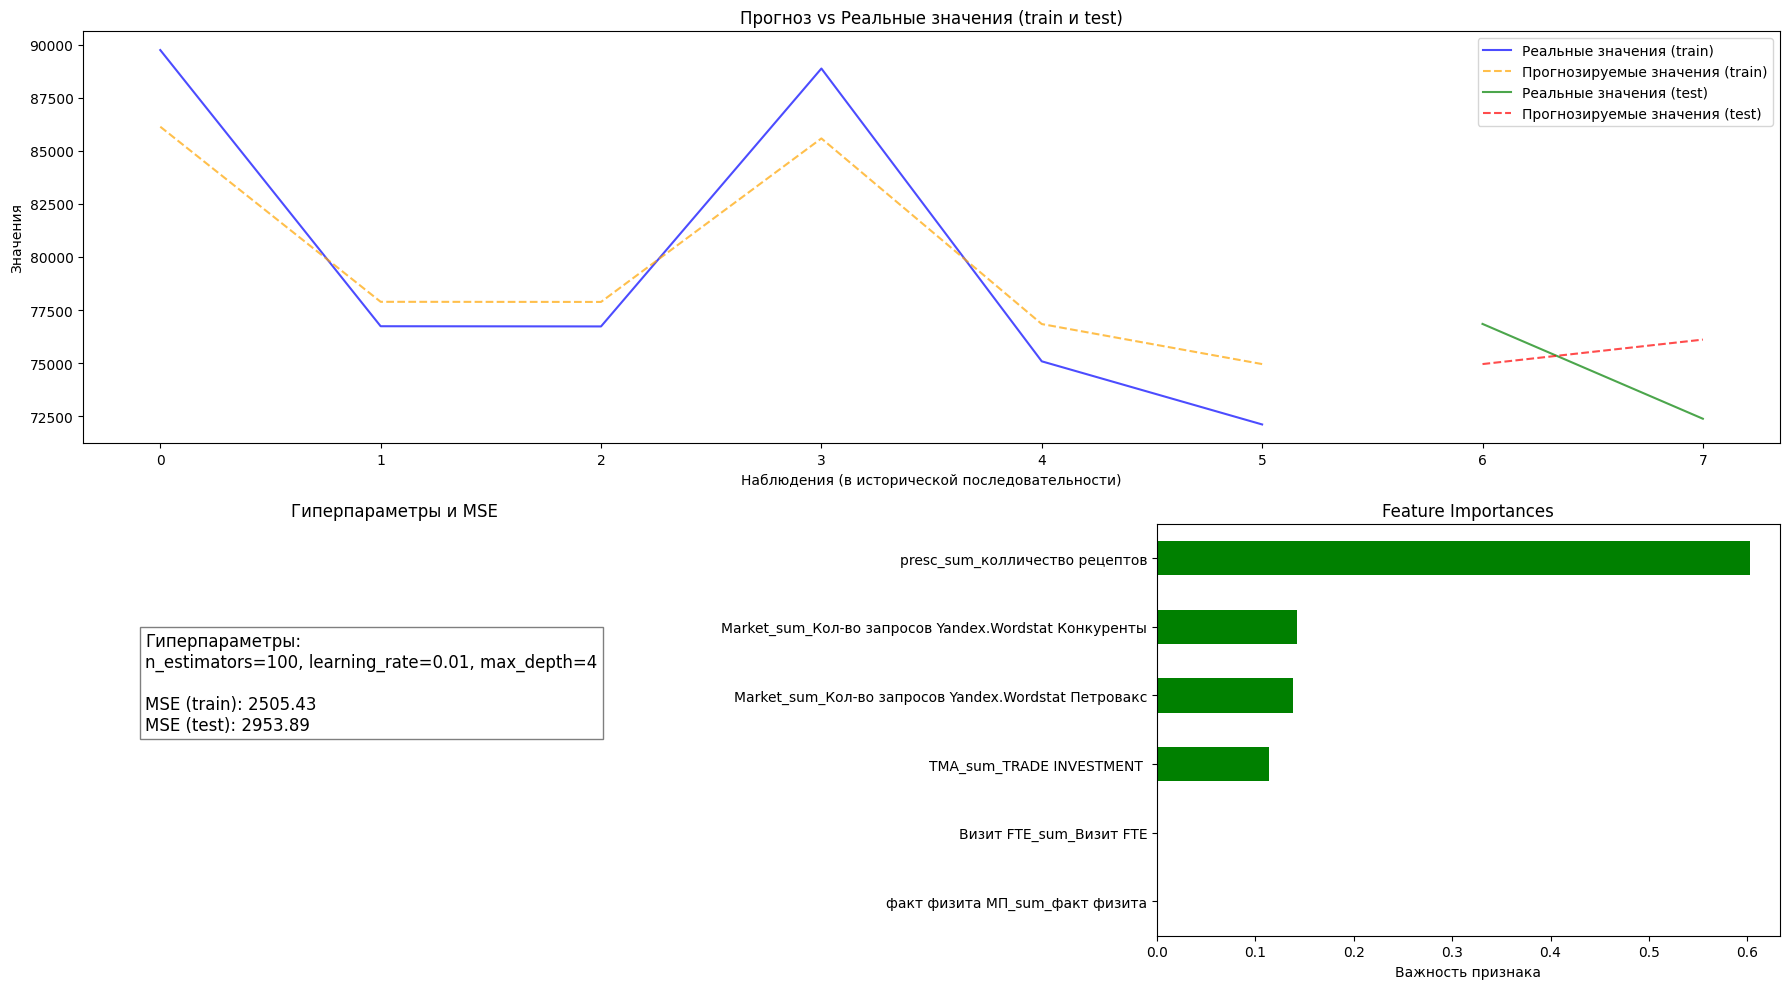

In [226]:
gradient_boosting_analysis(qfeats, features=gb_features, target=target, n_est=100, lr=0.01, max_depth=4)

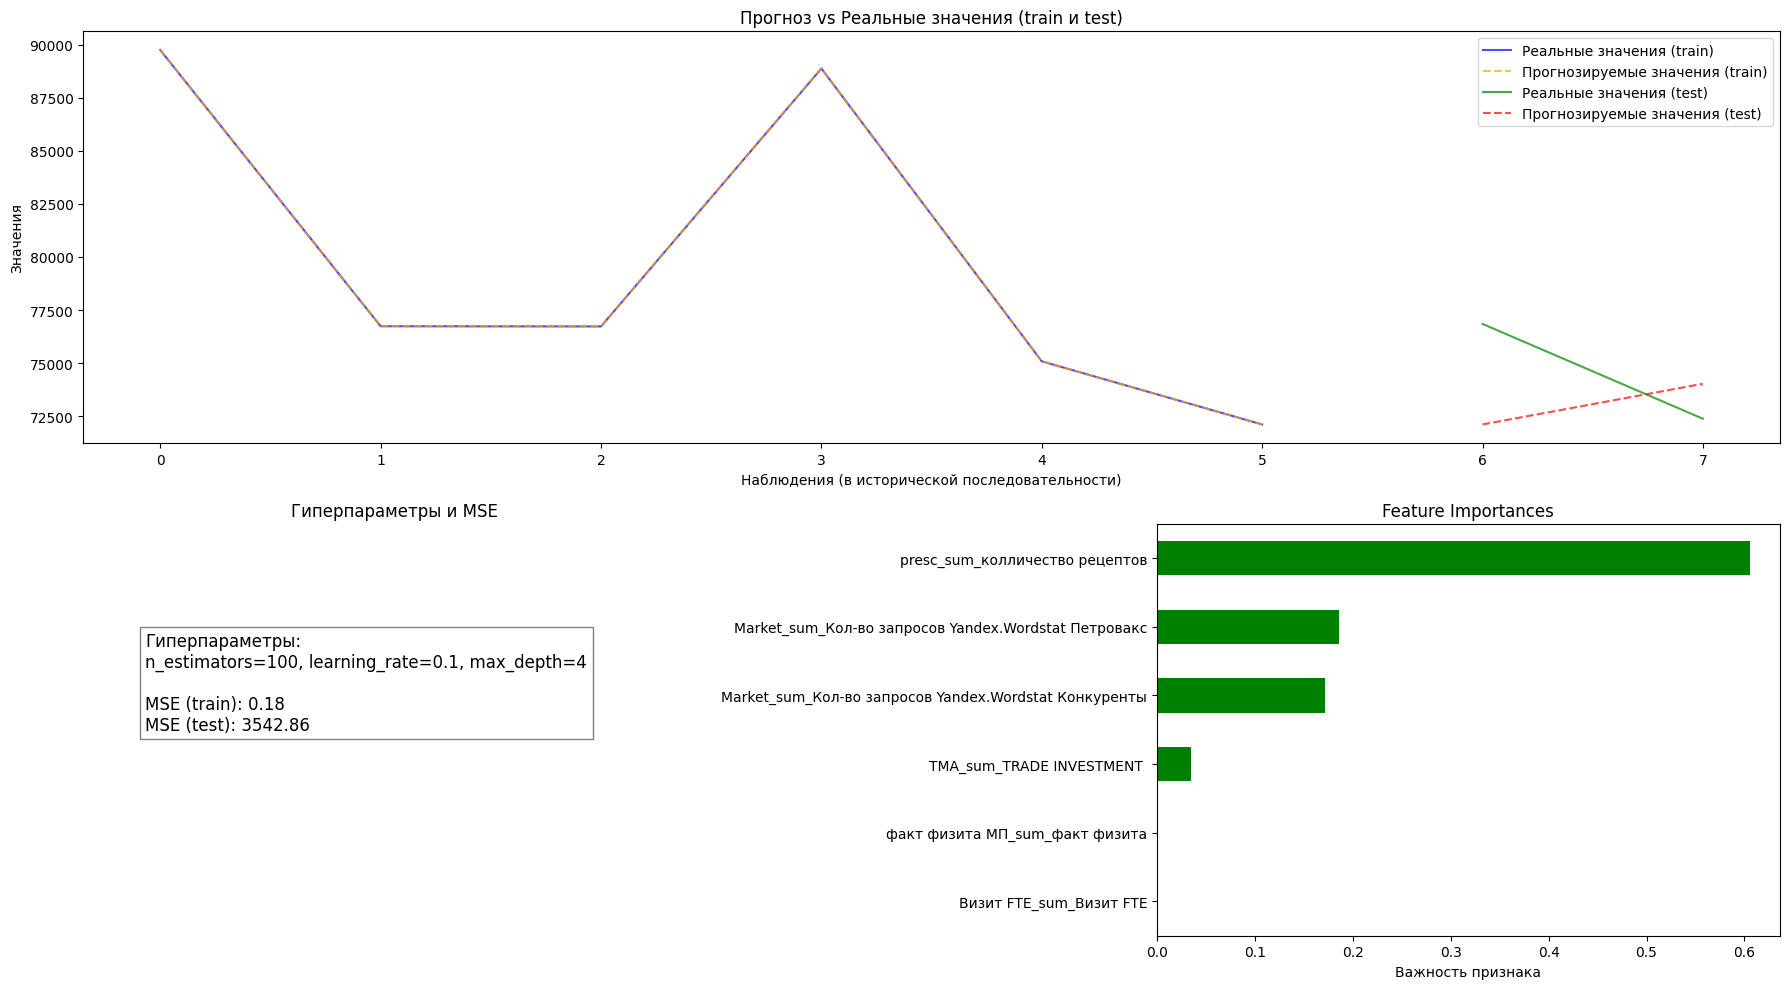

In [227]:
gradient_boosting_analysis(qfeats, features=gb_features, target=target, n_est=100, lr=0.1, max_depth=4)

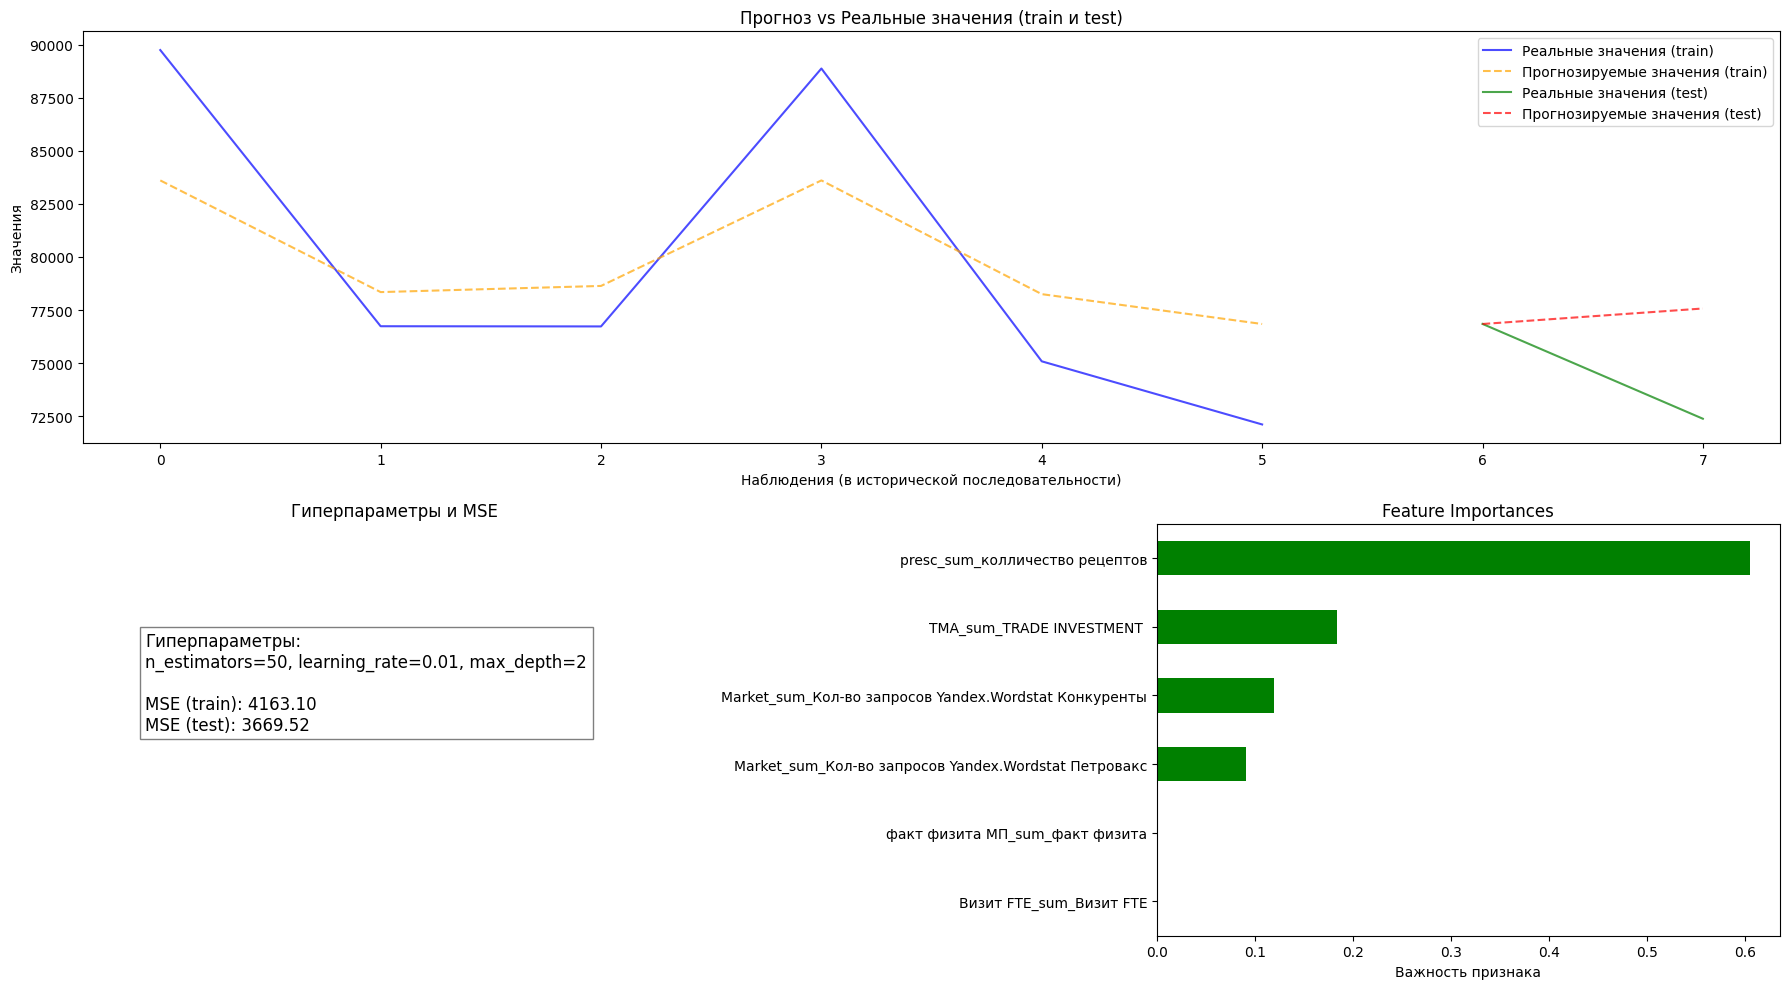

In [229]:
gradient_boosting_analysis(qfeats, features=gb_features, target=target, n_est=50, lr=0.01, max_depth=2)

### 2. Поиск интересных корреляций

Возьмем данные из qfeats (сгенерированный датафрейм на этапе 1.2.2)

In [230]:
# еще раз взглянем на qfeats
qfeats

Market_median_Кол-во запросов Yandex.Wordstat Конкуренты  \
год  квартал                                                              
2023 1                                                  647172.0          
     2                                                  505500.0          
     3                                                  506862.0          
     4                                                  669258.0          
2024 1                                                  761448.0          
     2                                                  577224.0          
     3                                                  541537.5          
     4                                                  664908.0          

               Market_median_Кол-во запросов Yandex.Wordstat Петровакс  \
год  квартал                                                             
2023 1                                                   18261.0         
     2                                                   13566.0         
     3                                                   14253.0         
     4                                                   19440.0         
2024 1                                                   21168.0         
     2                                                   15744.0         
     3                                                   15198.0         
     4                                                   19293.0         

               Market_median_Продажи (упаковки) Конкуренты  \
год  квартал                                                 
2023 1                                           255759.17   
     2                                           233126.64   
     3                                           231050.94   
     4                                           269383.68   
2024 1                                           269914.26   
     2                                           241712.12   
     3                                           243854.79   
     4                                           266107.70   

               Market_median_Продажи (упаковки) Петровакс  \
год  квартал                                                
2023 1                                            6265.95   
     2                                            5897.06   
     3                                            5895.58   
     4                                            6853.14   
2024 1                                            5996.96   
     2                                            5595.14   
     3                                            5529.28   
     4                                            6056.90   

               Market_median_Цена за 1 упаковку Конкуренты  \
год  квартал                                                 
2023 1                                          437.111998   
     2                                          445.936666   
     3                                          463.762213   
     4                                          464.661242   
2024 1                                          489.260113   
     2                                          507.000743   
     3                                          513.370583   
     4                                          526.754561   

               Market_median_Цена за 1 упаковку Петровакс  \
год  квартал                                                
2023 1                                         538.857389   
     2                                         525.447331   
     3                                         537.517444   
     4                                         531.468811   
2024 1                                         608.344052   
     2                                         663.766439   
     3                                         679.612549   
     4                                         684.720024   

               Market_mean_Кол-во ТВ рейтингов Конкуренты  

In [250]:
from sklearn.preprocessing import MinMaxScaler
from difflib import SequenceMatcher

def is_similar(feature_name, target_feature, threshold=0.7):
    """
    Проверяет, насколько похоже название признака на целевой признак.
    
    Параметры:
    - feature_name (str): Название признака.
    - target_feature (str): Целевой признак.
    - threshold (float): Порог схожести (по умолчанию 0.7).
    
    Возвращает:
    - bool: True, если схожесть превышает порог, иначе False.
    """
    similarity = SequenceMatcher(None, feature_name, target_feature).ratio()
    return similarity >= threshold

def plot_top_correlated_features(qfeats, target_feature):
    """
    Функция для отображения топ-6 наиболее скоррелированных признаков с целевым признаком.
    
    Параметры:
    - qfeats (pd.DataFrame): Исходный DataFrame с данными.
    - target_feature (str): Целевой признак, для которого строится анализ.
    
    Возвращает:
    - None: Результаты выводятся в виде графиков.
    """
    # 1. Проверка наличия целевого признака
    if target_feature not in qfeats.columns:
        raise ValueError(f"Целевой признак '{target_feature}' отсутствует в DataFrame.")
    
    # 2. Исключение признаков, названия которых слишком похожи на целевой признак
    filtered_columns = [
        col for col in qfeats.columns
        if col == target_feature or not is_similar(col, target_feature, threshold=0.7)
    ]
    qfeats_filtered = qfeats[filtered_columns]
    
    # 3. Оставляем только числовые столбцы
    qfeats_filtered = qfeats_filtered.select_dtypes(include=[np.number])
    
    # 4. Заполняем пропущенные значения нулями
    qfeats_filtered.fillna(0, inplace=True)
    
    # 5. Рассчитываем корреляцию между целевым признаком и остальными признаками
    correlation = qfeats_filtered.corr()[target_feature].drop(target_feature).abs().sort_values(ascending=False)
    
    # 6. Отбираем топ-6 признаков по корреляции
    top_features = correlation.head(6).index.tolist()
    
    # 7. Нормализуем данные с помощью MinMaxScaler
    scaler = MinMaxScaler()
    scaled_data = pd.DataFrame(
        scaler.fit_transform(qfeats_filtered),
        columns=qfeats_filtered.columns,
        index=qfeats_filtered.index
    )
    
    # 8. Строим графики
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # Преобразуем массив осей в одномерный для удобства
    
    for i, feature in enumerate(top_features):
        ax = axes[i]
        
        # Извлекаем данные для целевого и текущего признака
        target_scaled = scaled_data[target_feature]
        feature_scaled = scaled_data[feature]
        
        # Строим графики
        ax.plot(target_scaled, label=f"{target_feature} (целевой)", color='blue', alpha=0.7)
        ax.plot(feature_scaled, label=f"{feature}", color='orange', linestyle='--', alpha=0.7)
        
        # Добавляем заголовок с корреляцией
        corr_value = qfeats_filtered[target_feature].corr(qfeats_filtered[feature])
        ax.set_title(f"Корреляция: {corr_value:.2f}")
        
        # Добавляем легенду
        ax.legend(loc='upper left')
    
    # Удаляем лишние оси, если их больше, чем нужно
    for j in range(len(top_features), len(axes)):
        axes[j].axis('off')
    
    # Общий заголовок для всех графиков
    fig.suptitle(f"Топ-6 признаков, скоррелированных с '{target_feature}'", fontsize=16)
    
    # Отображаем графики
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Оставляем место для общего заголовка
    plt.show()

In [251]:
qfeats.fillna(0, inplace=True)
# Сброс индекса, если он является мультииндексом
qfeats = qfeats.reset_index(drop=True)

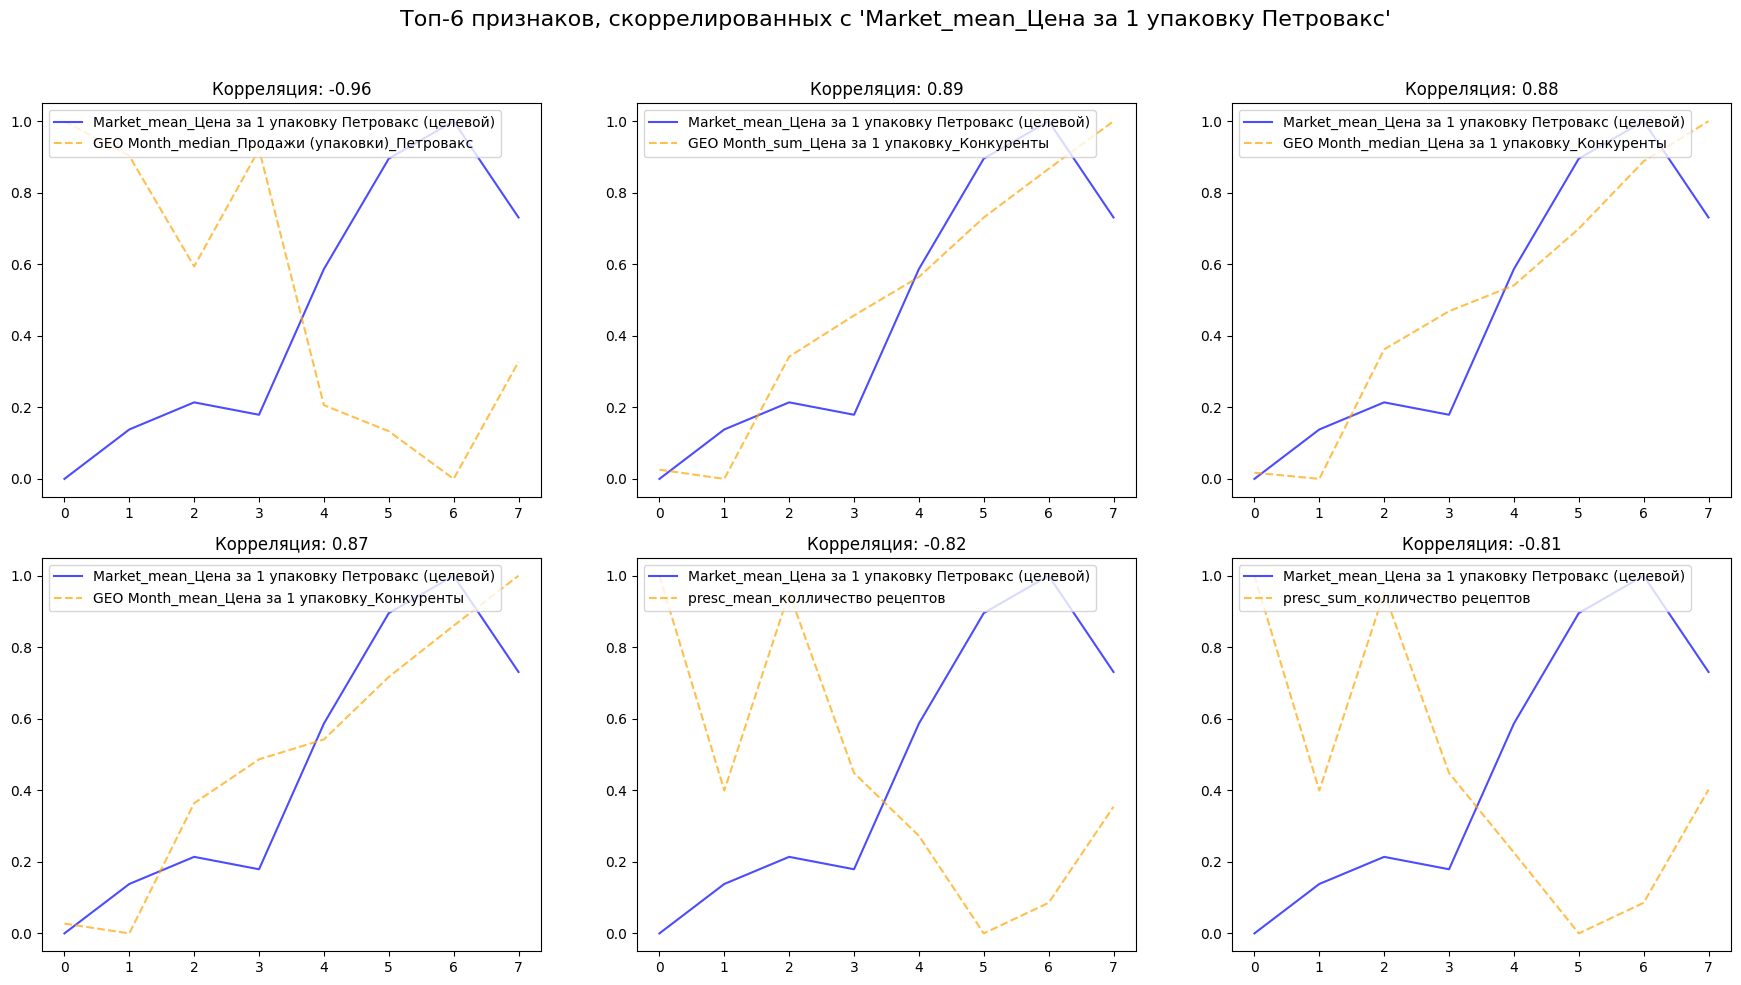

In [252]:
plot_top_correlated_features(qfeats=qfeats, target_feature='Market_mean_Цена за 1 упаковку Петровакс')

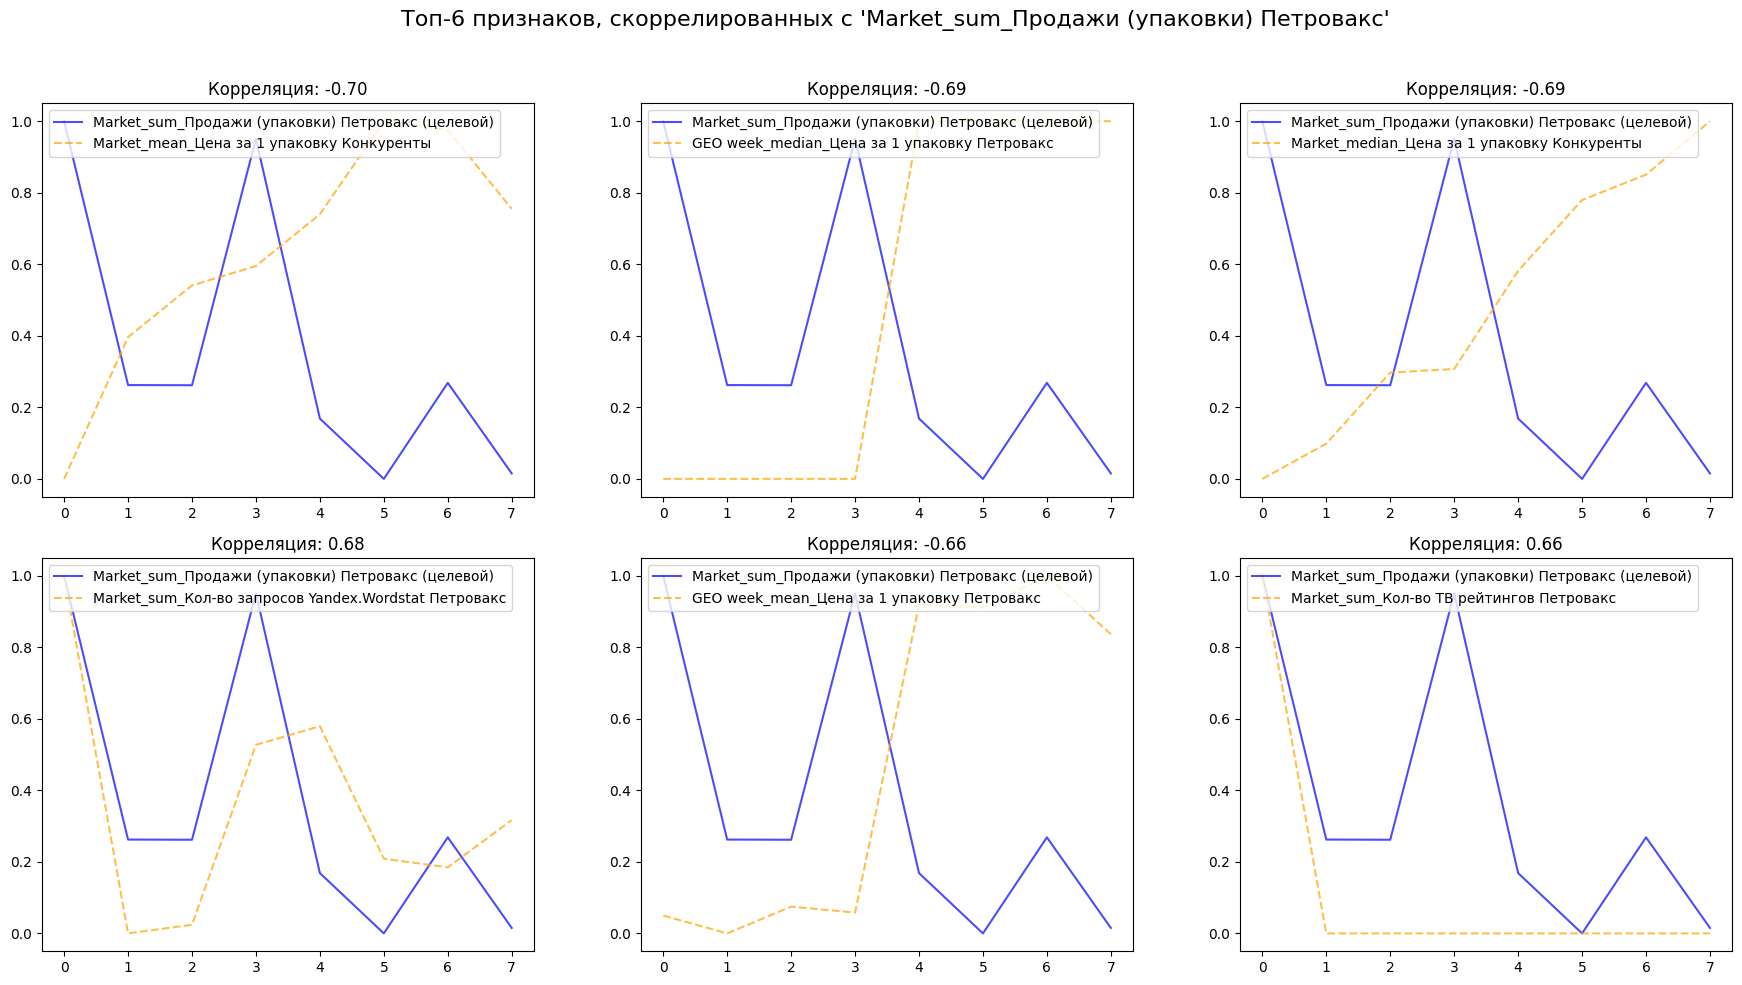

In [253]:
plot_top_correlated_features(qfeats=qfeats, target_feature='Market_sum_Продажи (упаковки) Петровакс')

Очевидно, что в функцию следует добавить условие, которое не будет учитывать признаки, данных по которым недостаточно, либо можно удалить такие признаки из исходной таблицы. Для примера, того, что приведено выше, достаточно

### 3. Итог

1. Проанализирована исходная таблица, перечислены основные составляющие ее источники, срезы по времени, признакам
2. Графически отражена динамика помесячных продаж и цен для двух источников (Market, Geo Month) по Конкурентам и Петровакс  
3. Продемонстрирована неробастность усреднения и почему медианные показатели устойчивее к выбросам
4. Продемонстрировано, что цены Петровакс согласно Market сильно выше цен конкурентов
5. Продемонстрировано, что SARIMA способна прогнозировать временной ряд продаж, но с ценами справляется плохо
6. Продемонстрировано, что GradientBoostingRegressor способен делать прогнозы поквартальных показателей продаж, приведено несколько примеров моделей с различными гиперпараметрами, на графиках приведена значимость признаков, которая показывает силу влияния признака на результат
7. В рамках корреляционного анализа приведены примеры признаков, которые наиболее сильно связаны с поквартальными Продажами и поквартальными Ценами